# Business Analytics Group 42

Please note that if you want to execute this notebook to place the Trips_2018.csv in a subfolder to this jupyter notebook called data.

- **src/**
  - **data/**
    - Trips_2018.csv
  - business_analytics_group_42.ipynb


# Importing all libraries

In [1]:
import math
import os
import urllib
import zipfile
from typing import Union

import contextily as ctx
import folium
import geopandas as gpd
import holidays
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from kneed import KneeLocator
from scipy.spatial.distance import cdist
from shapely.geometry import box
from sklearn.cluster import DBSCAN, KMeans
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import davies_bouldin_score, mean_squared_error, silhouette_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import NearestNeighbors
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression import yule_walker
from statsmodels.tsa.stattools import adfuller

ArrayLike1D = Union[np.ndarray, pd.Series, list]

def add_row(df, row_dict):
    if df.empty:
        return pd.DataFrame([row_dict])
    return pd.concat([df, pd.DataFrame([row_dict])], ignore_index=True)

## Data Analysis and Visualization

Figure 1: End stations

In [2]:
df = pd.read_csv('data/Trips_2018.csv')

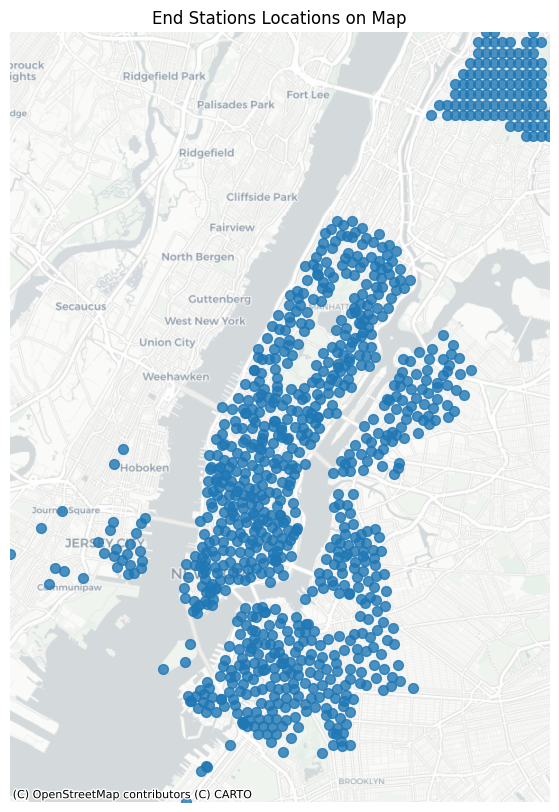

In [3]:
df_unique_end_stations = df[['end_station_id', 'end_station_latitude', 'end_station_longitude']].drop_duplicates()

# Step 1: Create a GeoDataFrame for the station points
# gdf_stations = gpd.GeoDataFrame(df_unique_end_stations, geometry=gpd.points_from_xy( df_unique_end_stations['start_station_longitude'],df_unique_end_stations['start_station_latitude']),crs="EPSG:4326" )

df_filtered = df_unique_end_stations[
    (df_unique_end_stations['end_station_latitude'] < 45) &
    (df_unique_end_stations['end_station_latitude'] > 40)
]
gdf_stations = gpd.GeoDataFrame(
    df_filtered,
    geometry=gpd.points_from_xy(
        df_filtered['end_station_longitude'],
        df_filtered['end_station_latitude']
    ),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Step 2: Reproject stations to Web Mercator
gdf_stations = gdf_stations.to_crs(epsg=3857)

# Step 3: Create bounding box from dataset (for map zoom)
min_lon = df_filtered['end_station_longitude'].min()
max_lon = df_filtered['end_station_longitude'].max()
min_lat = df_filtered['end_station_latitude'].min()
max_lat = df_filtered['end_station_latitude'].max()

bbox = gpd.GeoDataFrame(
    geometry=[box(min_lon, min_lat, max_lon, max_lat)],
    crs="EPSG:4326"
).to_crs(epsg=3857)

xmin, ymin, xmax, ymax = bbox.total_bounds

# Step 4: Plot basemap + points
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Plot stations
gdf_stations.plot(
    ax=ax,
    #cmap='viridis',
    markersize=50,
    alpha=0.8
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title("End Stations Locations on Map")
ax.set_axis_off()
plt.show()


Figure 2: Relationship between age and gender:

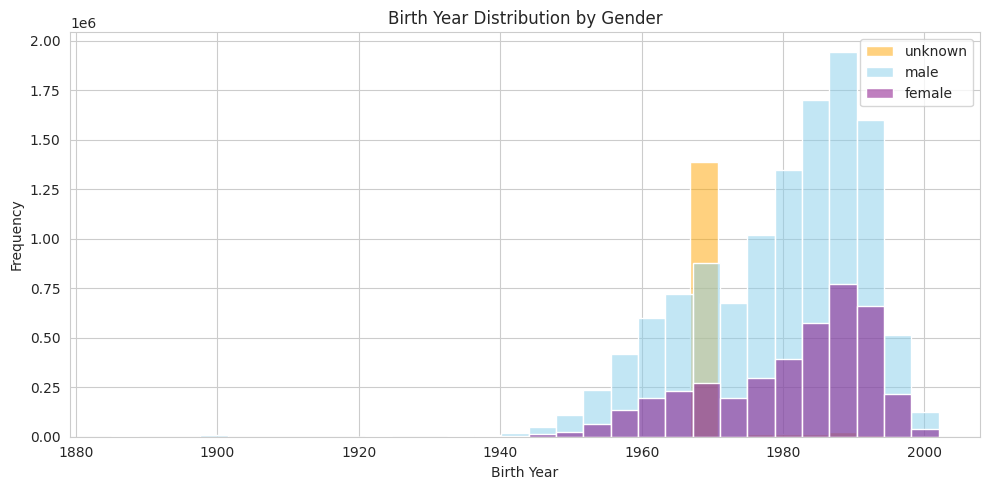

In [4]:
birthyear_gender0 = df[df['gender'] == 0]["birth_year"].dropna()
birthyear_gender1 = df[df['gender'] == 1]["birth_year"].dropna()
birthyear_gender2 = df[df['gender'] == 2]["birth_year"].dropna()

plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

sns.histplot(birthyear_gender0, bins=30, kde=False, color='orange', label='unknown', alpha=0.5)
sns.histplot(birthyear_gender1, bins=30, kde=False, color='skyblue', label='male', alpha=0.5)
sns.histplot(birthyear_gender2, bins=30, kde=False, color='purple', label='female', alpha=0.5)

plt.xlabel("Birth Year")
plt.ylabel("Frequency")
plt.title("Birth Year Distribution by Gender")
plt.legend()
plt.tight_layout()
plt.show()


Figure 3: Weekday vs weekend distribution

In [5]:
us_holidays_2018 = holidays.UnitedStates(years=[2018])
print(us_holidays_2018)

df['starttime'] = pd.to_datetime(df['starttime'])
df['date'] = df['starttime'].dt.date
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['starttime'].dt.hour
df['weekday'] = df['starttime'].dt.weekday  

df['is_holiday'] = df['date'].apply(lambda x: x in us_holidays_2018) 
df['is_weekend'] = df['weekday'] >= 5 
df['is_weekday'] = (~df['is_weekend']) 

daily_counts = df.groupby(['date','is_weekend']).size().reset_index(name='pickups')

avg_by_weekend = daily_counts.groupby('is_weekend')['pickups'].mean().reset_index()
avg_by_weekend['weekday_type'] = avg_by_weekend['is_weekend'].map({False:'Weekday', True:'Weekend'})
print("Average pickups (Weekday vs Weekend):")
print(avg_by_weekend[['weekday_type','pickups']])

{datetime.date(2018, 1, 1): "New Year's Day", datetime.date(2018, 5, 28): 'Memorial Day', datetime.date(2018, 7, 4): 'Independence Day', datetime.date(2018, 9, 3): 'Labor Day', datetime.date(2018, 11, 11): 'Veterans Day', datetime.date(2018, 11, 12): 'Veterans Day (observed)', datetime.date(2018, 11, 22): 'Thanksgiving Day', datetime.date(2018, 12, 25): 'Christmas Day', datetime.date(2018, 1, 15): 'Martin Luther King Jr. Day', datetime.date(2018, 2, 19): "Washington's Birthday", datetime.date(2018, 10, 8): 'Columbus Day'}
Average pickups (Weekday vs Weekend):
  weekday_type       pickups
0      Weekday  51007.827586
1      Weekend  40724.000000


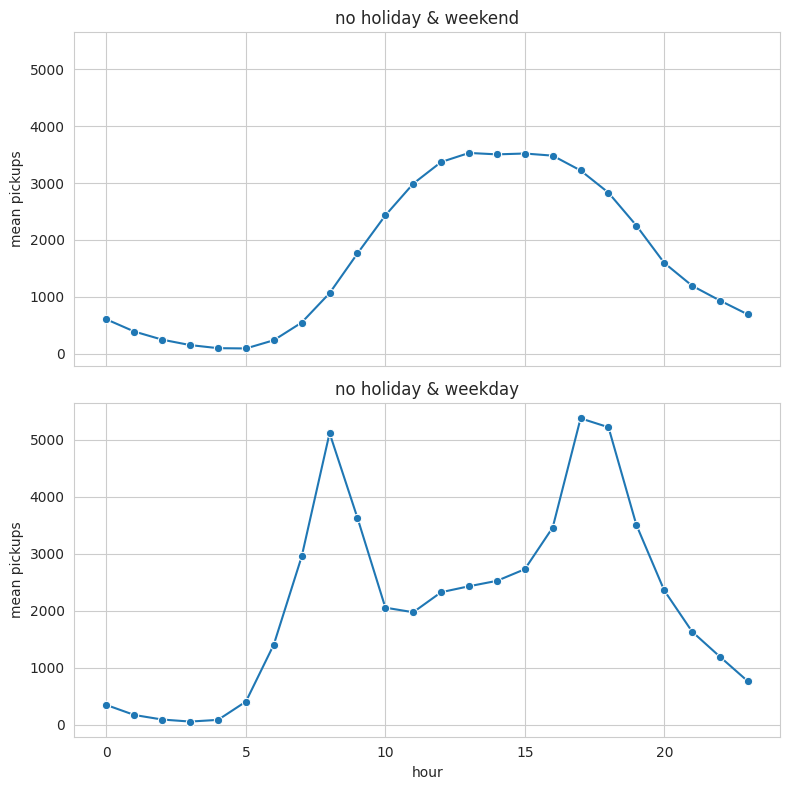

In [6]:
hourly_counts = df.groupby(['date','hour','is_holiday','is_weekend','is_weekday']).size().reset_index(name='pickups')
hourly_mean = hourly_counts.groupby(['hour','is_holiday','is_weekend','is_weekday'])['pickups'].mean().reset_index()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,8), sharex=True, sharey=True)

categories = [
    (False, True, 'no holiday & weekend'),
    (False, False, 'no holiday & weekday')
]

for ax, (isholiday, isweekend, title) in zip(axes, categories):
    subset = hourly_mean[
        (hourly_mean['is_holiday'] == isholiday) & 
        (hourly_mean['is_weekend'] == isweekend)
    ]
    sns.lineplot(x='hour', y='pickups', data=subset, marker='o', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('hour')
    ax.set_ylabel('mean pickups')
    ax.grid(True)

plt.tight_layout()
plt.show()


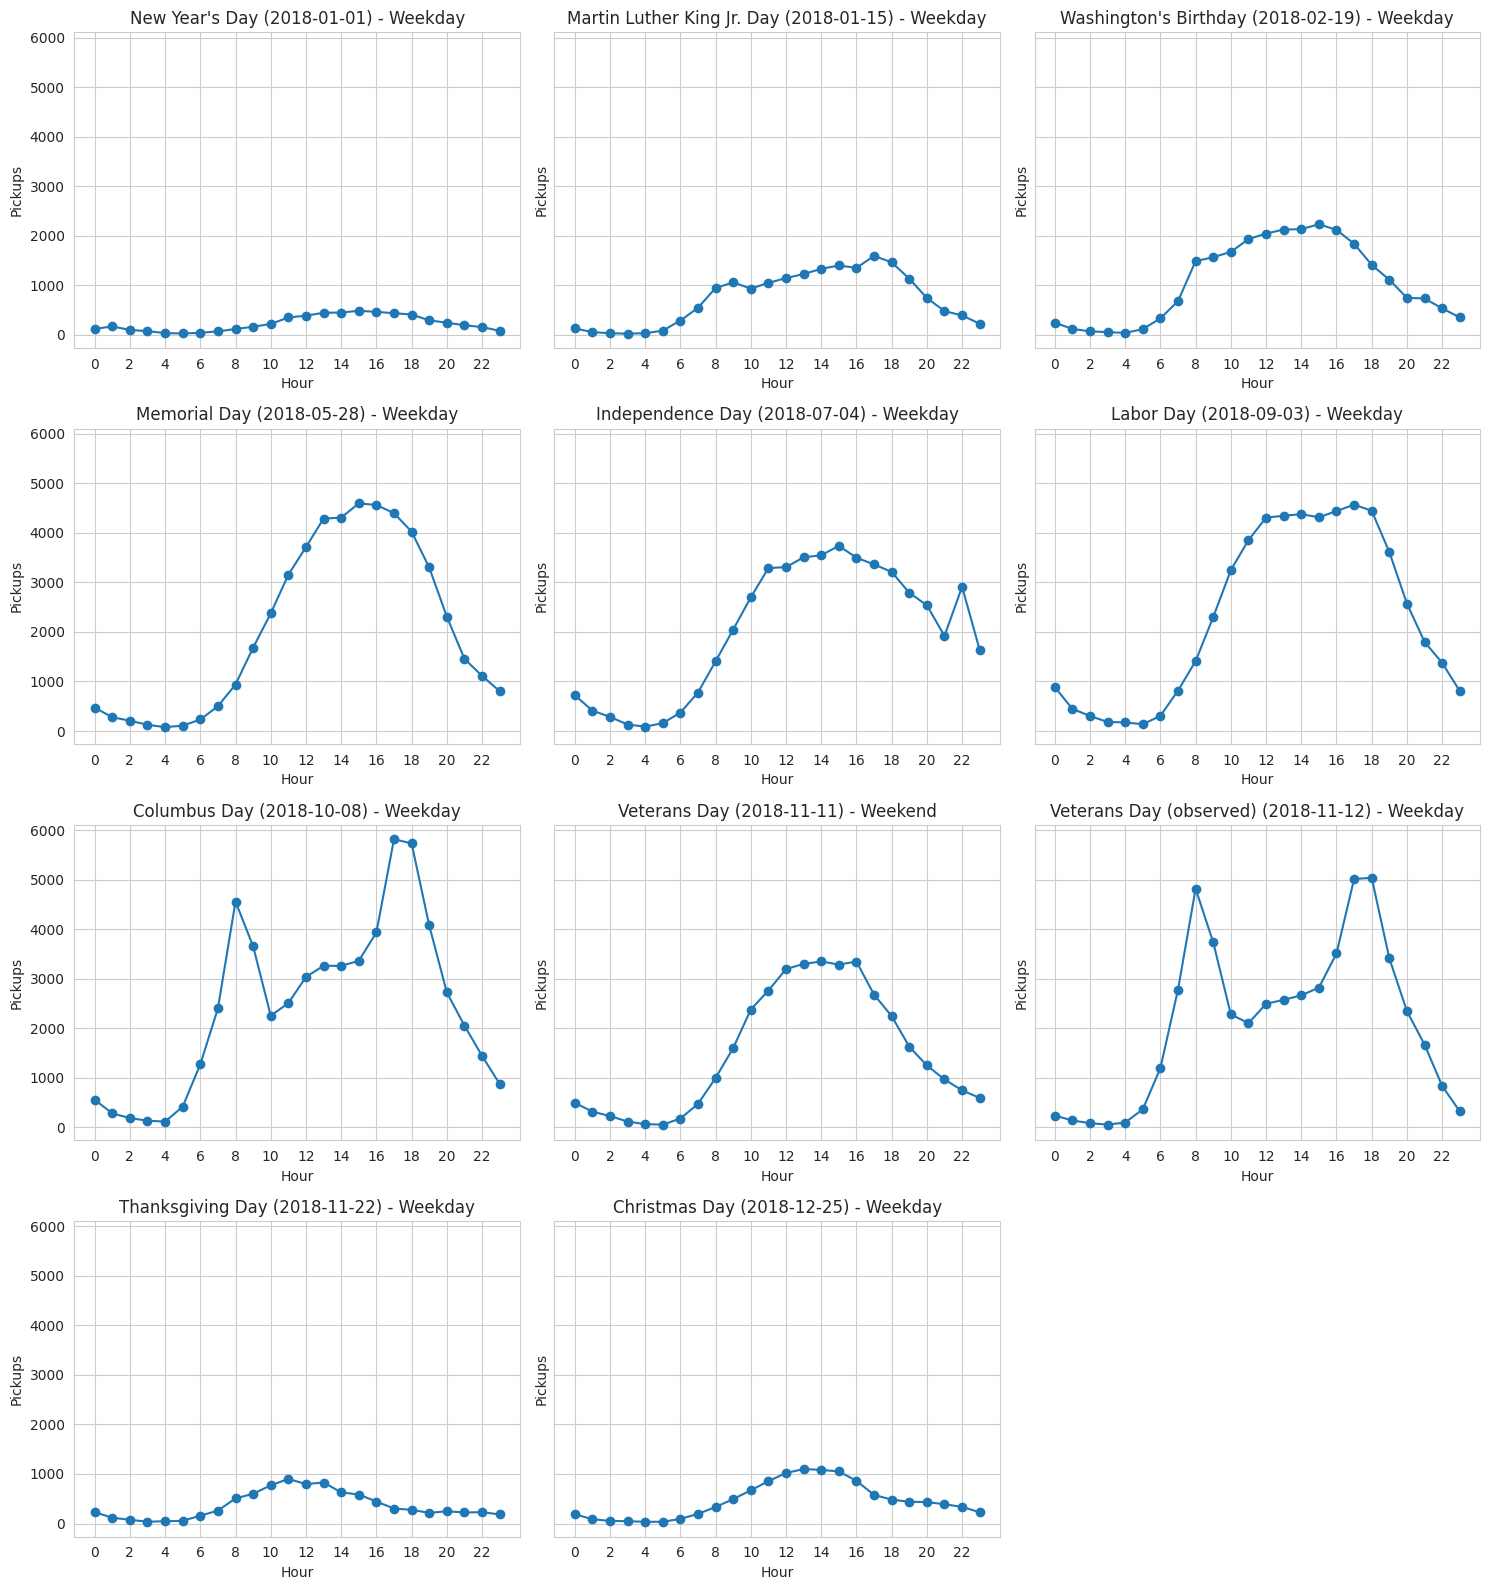

In [7]:

df['date_only'] = df['date'].dt.date
df_holidays = df[df['date_only'].isin(us_holidays_2018)]

hourly_counts = df_holidays.groupby(['date_only', 'hour']).size().reset_index(name='pickups')
unique_dates = sorted(hourly_counts['date_only'].unique())
n = len(unique_dates)
cols = 3
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5*cols,4*rows), sharey=True)
axes = axes.flatten()

# make a plot for each holiday to see the difference of e.g christmas 
for i, day in enumerate(unique_dates):
    df_day = hourly_counts[hourly_counts['date_only'] == day]
    holiday_name = us_holidays_2018[day]
    
    # is it a week day or week e d
    weekday_status = "Weekend" if day.weekday() >= 5 else "Weekday"
    
    axes[i].plot(df_day['hour'], df_day['pickups'], marker='o')
    axes[i].set_title(f"{holiday_name} ({day}) - {weekday_status}")
    axes[i].set_xlabel("Hour")
    axes[i].set_ylabel("Pickups")
    axes[i].set_xticks(range(0,24,2))

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Prediction Challange

### Clustering

In [8]:
df = pd.read_csv('data/Trips_2018.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.dropna(subset=['start_station_id'])
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])
df_unique_start_stations = df[['start_station_id', 'start_station_latitude', 'start_station_longitude']].drop_duplicates().reset_index()
df_unique_start_stations = df_unique_start_stations.drop(columns=['index'])

df_unique_start_stations = df_unique_start_stations[~(df_unique_start_stations['start_station_latitude'] > 45)]
counts = df.groupby('start_station_id').size()
df_unique_start_stations['num_users'] = df_unique_start_stations['start_station_id'].map(counts)

Inertia values:


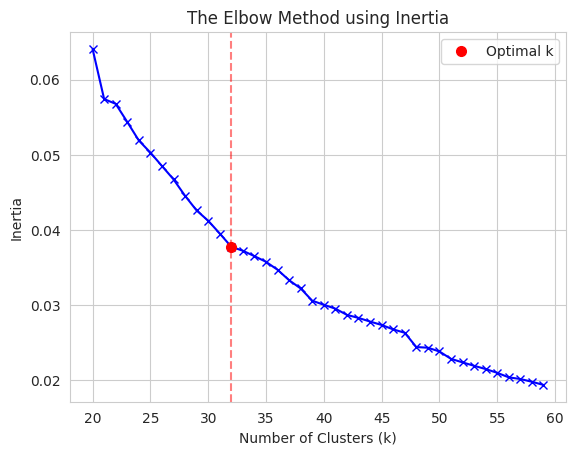

Optimal number of clusters: 32


In [9]:
distortions = list()
inertias = list()
mapping1 = dict()
mapping2 = dict()

K = range(20, 60)

for k in K:
    KMeans_model = KMeans(n_clusters=k, random_state=1711).fit(df_unique_start_stations[['start_station_latitude', 'start_station_longitude']])
    distortions.append(sum(np.min(cdist(df_unique_start_stations[['start_station_latitude', 'start_station_longitude']], KMeans_model.cluster_centers_, 'euclidean'), axis=1)**2) / df_unique_start_stations[['start_station_latitude', 'start_station_longitude']].shape[0])

    inertias.append(KMeans_model.inertia_)

    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]


# Use KneeLocator to find the elbow point
knee_inertia = KneeLocator(K, inertias, curve='convex', direction='decreasing')
optimal_k = knee_inertia.knee
print("Inertia values:")
for key, val in mapping2.items():
    pass
    #print(f'{key} : {val}')

plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.plot(optimal_k, inertias[optimal_k-20], 'ro', markersize=7, label='Optimal k')  # Red dot
plt.axvline(x=optimal_k, color='r', linestyle='--', alpha=0.5)  # Optional vertical line

plt.legend()
plt.show()

print("Optimal number of clusters:", optimal_k)

In [10]:
## Fitting the model with the optimal number of clusters
KMeans_model = KMeans(n_clusters=optimal_k, random_state=1711).fit(df_unique_start_stations[['start_station_latitude', 'start_station_longitude']])

Figure 4: Centroids from k-means

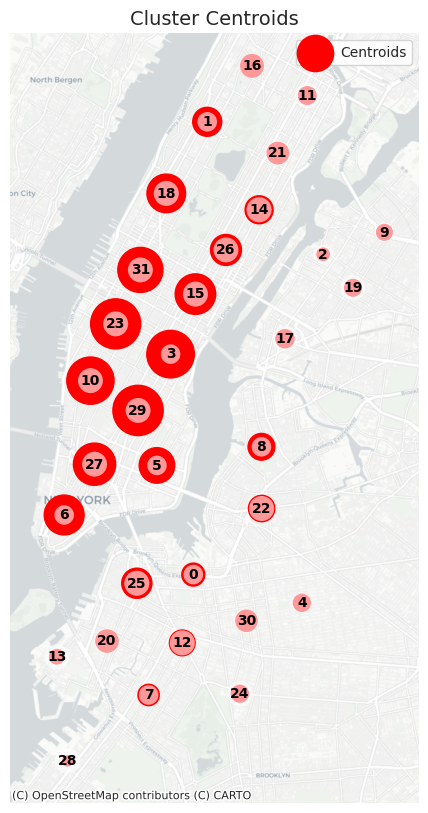

In [11]:
df_unique_start_stations['cluster_label'] = KMeans_model.labels_

avg_num_user_cluster = df_unique_start_stations.groupby('cluster_label')['num_users'].mean()


# Step 1: Create GeoDataFrame for centroids (assuming KMeans used lon/lat)
centroids = KMeans_model.cluster_centers_
gdf_centroids = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(centroids[:, 1], centroids[:, 0]),
    crs="EPSG:4326"
)
gdf_centroids = gdf_centroids.to_crs(epsg=3857)

size_scale = 0.025  # adjust this to make bubbles bigger/smaller
gdf_centroids['avg_num_users'] = avg_num_user_cluster.values
marker_sizes = gdf_centroids['avg_num_users'] * size_scale



min_lon = df_unique_start_stations['start_station_longitude'].min()
max_lon = df_unique_start_stations['start_station_longitude'].max()
min_lat = df_unique_start_stations['start_station_latitude'].min()
max_lat = df_unique_start_stations['start_station_latitude'].max()


bbox = gpd.GeoDataFrame(
    geometry=[box(min_lon, min_lat, max_lon, max_lat)],
    crs="EPSG:4326"
).to_crs(epsg=3857)

xmin, ymin, xmax, ymax = bbox.total_bounds

# Step 4: Plot basemap + points
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)



# Plot only centroids
gdf_centroids.plot(ax=ax, color='red', markersize=marker_sizes, label='Centroids')

for i, row in enumerate(gdf_centroids.itertuples()):
    ax.text(
        row.geometry.x,
        row.geometry.y,
        str(i),                # label text (cluster number)
        fontsize=10,
        fontweight='bold',
        color='black',
        ha='center',
        va='center',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='circle,pad=0.2')
    )

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.set_title("Cluster Centroids", fontsize=14)
ax.legend()
ax.set_axis_off()
plt.show()

Figure 5: K-Distance graph

Unique stations before geo-filter: 819
Unique stations after geo-filter: 817


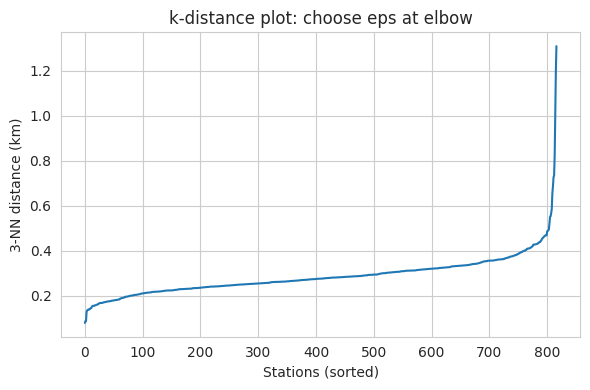

In [12]:
stations = (
    df[["start_station_id", "start_station_latitude", "start_station_longitude"]]
    .drop_duplicates()
    .dropna()
    .reset_index(drop=True)
)
print(f"Unique stations before geo-filter: {len(stations)}")

stations = stations[
    (stations["start_station_latitude"] > 35)
    & (stations["start_station_latitude"] < 45)
    & (stations["start_station_longitude"] > -80)
    & (stations["start_station_longitude"] < -70)
].copy()
print(f"Unique stations after geo-filter: {len(stations)}")

coords = stations[["start_station_latitude", "start_station_longitude"]].values
coords_radians = np.radians(coords)

# k-distance plot to help choose eps
kms_per_radian = 6371.0088
min_samples = 3

nn = NearestNeighbors(n_neighbors=min_samples, metric='haversine', algorithm='ball_tree')
nn.fit(coords_radians)
distances, _ = nn.kneighbors(coords_radians)
k_distances_km = np.sort(distances[:, -1]) * kms_per_radian

plt.figure(figsize=(6, 4))
plt.plot(k_distances_km)
plt.ylabel(f'{min_samples}-NN distance (km)')
plt.xlabel('Stations (sorted)')
plt.title('k-distance plot: choose eps at elbow')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
def run_dbscan(coords_radians, eps_km, min_samples=3, kms_per_radian=6371.0088):
    eps = eps_km / kms_per_radian
    model = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine')
    labels = model.fit_predict(coords_radians)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = np.sum(labels == -1)
    noise_pct = 100 * n_noise / len(labels)
    print(f'  eps={eps_km:.3f} -> clusters={n_clusters}, noise={n_noise} ({noise_pct:.1f}%)')
    return labels

print('\nDBSCAN eps sensitivity:')
for eps_test in [0.25, 0.30, 0.325, 0.35]:
    _ = run_dbscan(coords_radians, eps_km=eps_test)

print('\nFinal DBSCAN results')
eps_final = 0.325
eps = eps_final / kms_per_radian
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine')
dbscan_labels = dbscan_model.fit_predict(coords_radians)
stations['dbscan_cluster'] = dbscan_labels

n_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = np.sum(dbscan_labels == -1)
noise_pct = 100 * n_noise / len(dbscan_labels)

print(f'Clusters: {n_dbscan_clusters}')
print(f'Noise: {n_noise} ({noise_pct:.2f}%)')

dbscan_non_noise = dbscan_labels[dbscan_labels != -1]
coords_non_noise = coords[dbscan_labels != -1]
if len(set(dbscan_non_noise)) > 1:
    dbscan_silhouette = silhouette_score(coords_non_noise, dbscan_non_noise)
    print(f'Silhouette: {dbscan_silhouette:.4f}')

dbscan_sizes = pd.Series(dbscan_non_noise).value_counts().sort_index()
print(f'Mean cluster size: {dbscan_sizes.mean():.1f} (std {dbscan_sizes.std():.1f})')



DBSCAN eps sensitivity:
  eps=0.250 -> clusters=73, noise=426 (52.1%)
  eps=0.300 -> clusters=60, noise=172 (21.1%)
  eps=0.325 -> clusters=38, noise=88 (10.8%)
  eps=0.350 -> clusters=16, noise=55 (6.7%)

Final DBSCAN results
Clusters: 38
Noise: 88 (10.77%)
Silhouette: -0.0386
Mean cluster size: 19.2 (std 41.2)


Figure 6: Map of DBSCAN clusters

In [14]:
# Folium map visualization
def create_dbscan_folium_map(
    stations,
    cluster_col,
    center_lat=40.74,
    center_lon=-73.99,
    zoom_start=13,
):
    nyc_map = folium.Map(
        location=[center_lat, center_lon],
        zoom_start=zoom_start,
        tiles="CartoDB positron",
    )

    cluster_values = stations[cluster_col].values
    unique_clusters = sorted(c for c in set(cluster_values) if c != -1)

    colors_array = cm.rainbow(np.linspace(0, 1, len(unique_clusters)))
    color_list = [colors.rgb2hex(c) for c in colors_array]
    cluster_to_color = {cl: color_list[i] for i, cl in enumerate(unique_clusters)}

    for lat, lon, cl in zip(
        stations["start_station_latitude"],
        stations["start_station_longitude"],
        cluster_values,
    ):
        if cl == -1:
            col = "#000000"  # noise = black
            rad = 2
            opa = 0.4
        else:
            col = cluster_to_color[cl]
            rad = 4
            opa = 0.9

        folium.CircleMarker(
            location=[lat, lon],
            radius=rad,
            popup=f"Cluster: {cl}",
            color=col,
            fill=True,
            fill_color=col,
            fill_opacity=opa,
        ).add_to(nyc_map)

    return nyc_map

nyc_map = create_dbscan_folium_map(stations, "dbscan_cluster")
nyc_map

Table 1: Silhouette Score and clustersize standard deviation

In [15]:
print('\nFinal DBSCAN results')
eps_final = 0.325
eps = eps_final / kms_per_radian
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine')
dbscan_labels = dbscan_model.fit_predict(coords_radians)
stations['dbscan_cluster'] = dbscan_labels

n_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = np.sum(dbscan_labels == -1)
noise_pct = 100 * n_noise / len(dbscan_labels)

print(f'Clusters: {n_dbscan_clusters}')
print(f'Noise: {n_noise} ({noise_pct:.2f}%)')

dbscan_non_noise = dbscan_labels[dbscan_labels != -1]
coords_non_noise = coords[dbscan_labels != -1]
if len(set(dbscan_non_noise)) > 1:
    dbscan_silhouette = silhouette_score(coords_non_noise, dbscan_non_noise)
    print(f'Silhouette: {dbscan_silhouette:.4f}')

dbscan_sizes = pd.Series(dbscan_non_noise).value_counts().sort_index()
print(f'Mean cluster size: {dbscan_sizes.mean():.1f} (std {dbscan_sizes.std():.1f})')


# KMeans with 32 clusters
kmeans_model = KMeans(n_clusters=32, random_state=1711, n_init=10)
kmeans_labels = kmeans_model.fit_predict(coords)
stations['kmeans_cluster'] = kmeans_labels

n_kmeans_clusters = len(set(kmeans_labels))
kmeans_silhouette = silhouette_score(coords, kmeans_labels)
kmeans_db = davies_bouldin_score(coords, kmeans_labels)
print("-"*10)

print(f'Clusters: {n_kmeans_clusters}')
print(f'Silhouette: {kmeans_silhouette:.4f}')
print(f'Davies-Bouldin: {kmeans_db:.4f}')

kmeans_sizes = pd.Series(kmeans_labels).value_counts().sort_index()
print(f'Mean cluster size: {kmeans_sizes.mean():.1f} (std {kmeans_sizes.std():.1f})')



Final DBSCAN results
Clusters: 38
Noise: 88 (10.77%)
Silhouette: -0.0386
Mean cluster size: 19.2 (std 41.2)
----------
Clusters: 32
Silhouette: 0.3585
Davies-Bouldin: 0.8277
Mean cluster size: 25.5 (std 7.0)


### Time Series: ACF, PACF and Dickey-Fuller Test

/tmp/ipykernel_376326/1539251721.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['start_centroid'] = df_train['start_station_id'].map(station_to_cluster)
/tmp/ipykernel_376326/1539251721.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['end_centroid'] = df_train['end_station_id'].map(station_to_cluster)
/tmp/ipykernel_376326/1539251721.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

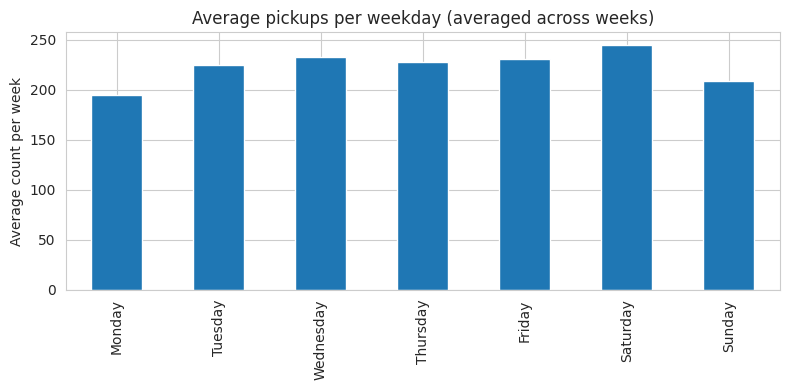

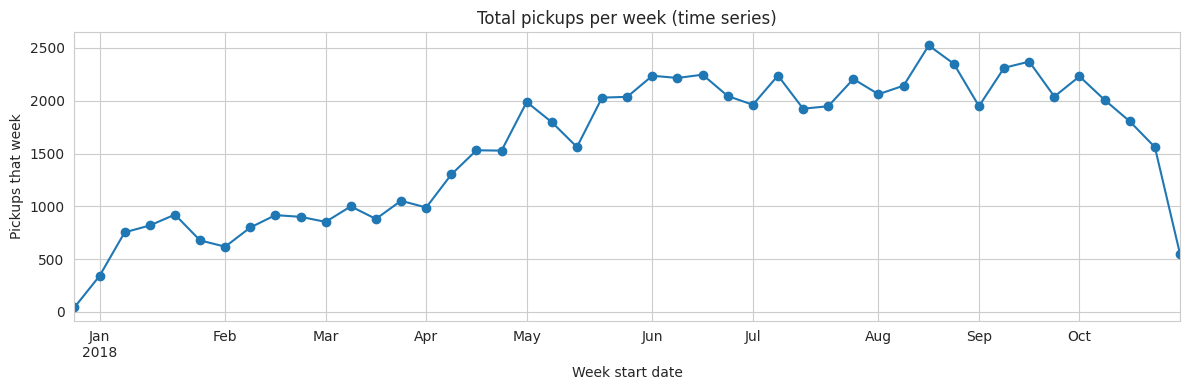

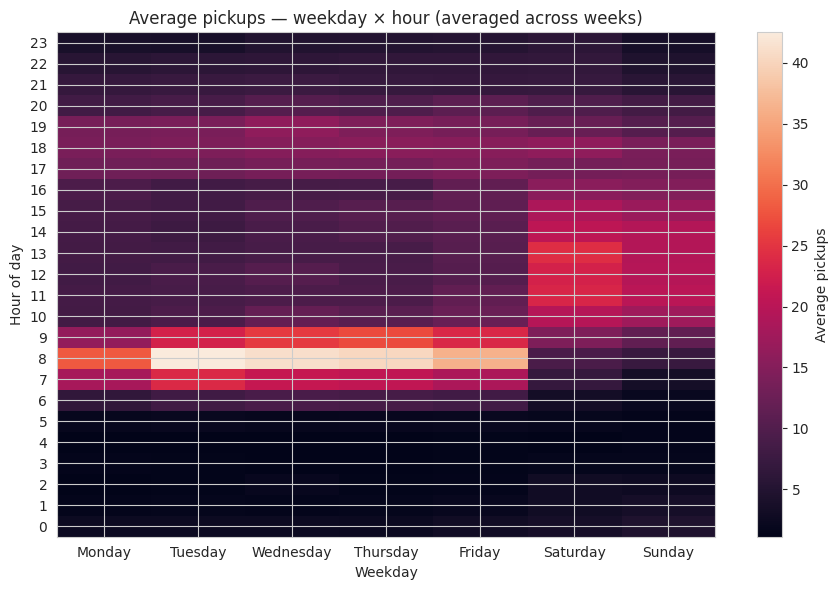

In [16]:
# Importing dataset and only selecting unique start stations
df = pd.read_csv('data/Trips_2018.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.dropna(subset='start_station_id')

df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

# Splitting into train (Jan-Oct) and Test (Nov-Dec)
df_train, df_test = df[df['starttime'].dt.month < 11], df[df['starttime'].dt.month >= 11]


# Data filtering and only selecting the unique
df_unique_start_stations = df_train[['start_station_id', 'start_station_latitude', 'start_station_longitude']].drop_duplicates().reset_index()
df_unique_start_stations = df_unique_start_stations.drop(columns=['index'])
df_unique_start_stations = df_unique_start_stations[~(df_unique_start_stations['start_station_latitude'] > 45)]

K = 32
KMeans_model = KMeans(
    n_clusters=K,
    random_state=1711
).fit(df_unique_start_stations[['start_station_latitude', 'start_station_longitude']])

# Assign each unique start station to one of the K clusters
df_unique_start_stations['cluster'] = KMeans_model.labels_

# Create a mapping: start_station_id → cluster index and dropping duplicates
station_to_cluster = (
    df_unique_start_stations
    .drop_duplicates(subset='start_station_id')
    .set_index('start_station_id')['cluster']
)

# Map start and end station IDs in the training dataset to their cluster labels
df_train['start_centroid'] = df_train['start_station_id'].map(station_to_cluster)
df_train['end_centroid'] = df_train['end_station_id'].map(station_to_cluster)
# Note: station 29 is clustered but the variable name is 29
df_cluster_31_train = df_train[df_train['start_centroid'] == 29]
df_cluster_31_train['starttime'] = pd.to_datetime(df_cluster_31_train['starttime'])
df_cluster_31_train['weekday'] = df_cluster_31_train['starttime'].dt.day_name()
df_cluster_31_train['weekday_num'] = df_cluster_31_train['starttime'].dt.weekday
df_cluster_31_train['hour'] = df_cluster_31_train['starttime'].dt.hour

# week starting Monday as timestamp (so each week is uniquely identified)
df_cluster_31_train['week_start'] = df_cluster_31_train['starttime'].dt.to_period('W-MON').apply(lambda r: r.start_time)

# Each day starting at midnight as timestamp (so each day is uniquely identified)
df_cluster_31_train['day_start'] = df_cluster_31_train['starttime'].dt.to_period('D').apply(lambda r: r.start_time)
# Resample by hour
df_cluster_31_train = df_cluster_31_train.set_index('starttime')
ts_train_31 = df_cluster_31_train.resample('H').size().rename('Count')



# Plot 1: Average pickup per week day
# Count pickups per (week_start, weekday) -> pivot -> mean across weeks
weekly_weekday = (df_cluster_31_train
                  .groupby(['week_start', 'weekday_num'])
                  .size()
                  .reset_index(name='count'))

pivot = weekly_weekday.pivot(index='week_start', columns='weekday_num', values='count').fillna(0)
# average across weeks
avg_per_weekday = pivot.mean(axis=0).reindex([0,1,2,3,4,5,6])  # ensure Mon..Sun order
weekday_names = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
avg_per_weekday.index = weekday_names

# Plot bar chart
plt.figure(figsize=(8,4))
avg_per_weekday.plot(kind='bar', legend=False)
plt.title('Average pickups per weekday (averaged across weeks)')
plt.xlabel('')
plt.ylabel('Average count per week')
plt.tight_layout()
plt.show()


# Plot 2: Total pickups per week
weekly_total = df_cluster_31_train.groupby('week_start').size().sort_index()

plt.figure(figsize=(12,4))
weekly_total.plot(kind='line', marker='o')
plt.title('Total pickups per week (time series)')
plt.xlabel('Week start date')
plt.ylabel('Pickups that week')
plt.tight_layout()
plt.show()


# Plot 3: Heatmap: average pickups per weekday × hour
weekly_wd_hour = (df_cluster_31_train
                  .groupby(['week_start','weekday_num','hour'])
                  .size()
                  .reset_index(name='count'))

avg_wd_hour = (weekly_wd_hour
               .groupby(['weekday_num','hour'])['count']
               .mean()
               .unstack(level=0)   # columns by weekday_num
               .fillna(0))

heat_data = avg_wd_hour.values

plt.figure(figsize=(9,6))
plt.imshow(heat_data, aspect='auto', origin='lower')
plt.colorbar(label='Average pickups')
plt.xticks(ticks=np.arange(7), labels=weekday_names)
plt.yticks(ticks=np.arange(0,24), labels=np.arange(0,24))
plt.xlabel('Weekday')
plt.ylabel('Hour of day')
plt.title('Average pickups — weekday × hour (averaged across weeks)')
plt.tight_layout()
plt.show()



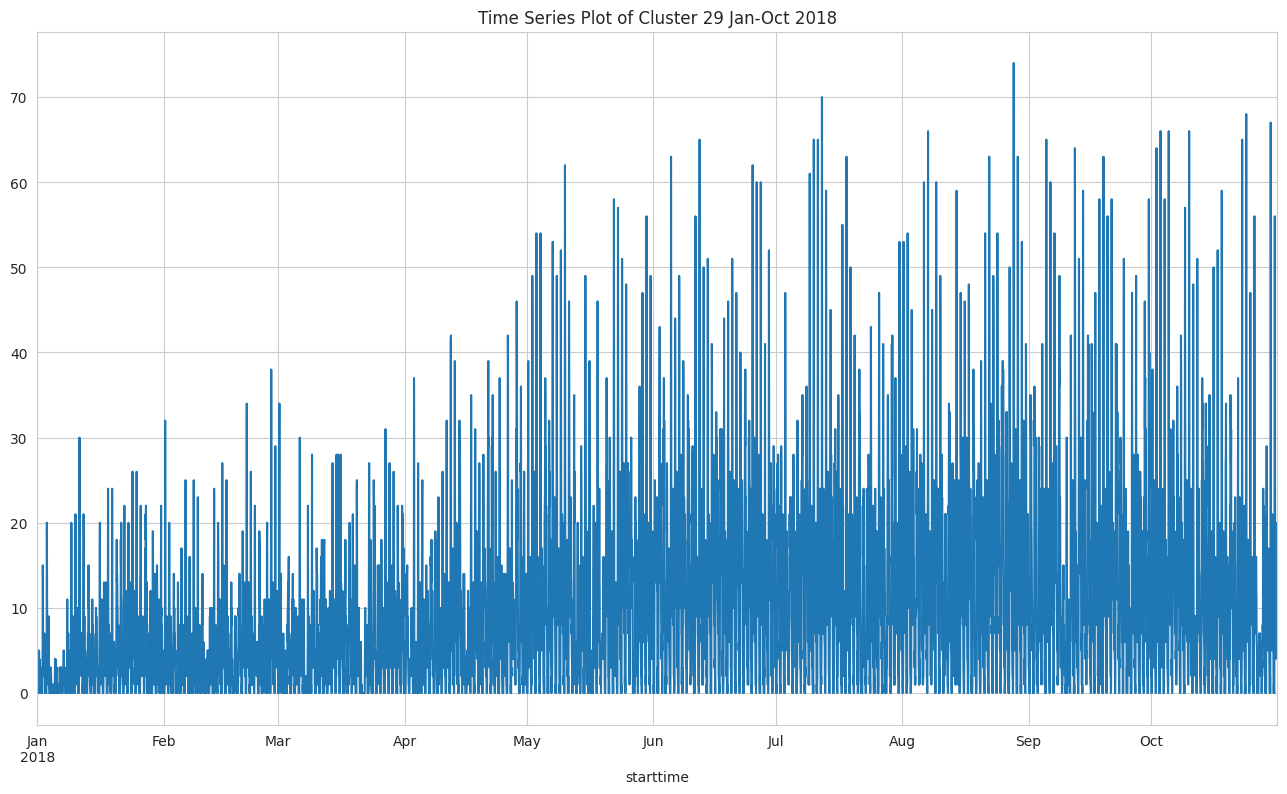

In [17]:
plt.figure(figsize=(16,9))
plt.title("Time Series Plot of Cluster 29 Jan-Oct 2018")
ts_train_31.plot()
plt.show()

In [18]:
result = adfuller(ts_train_31)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.879212
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


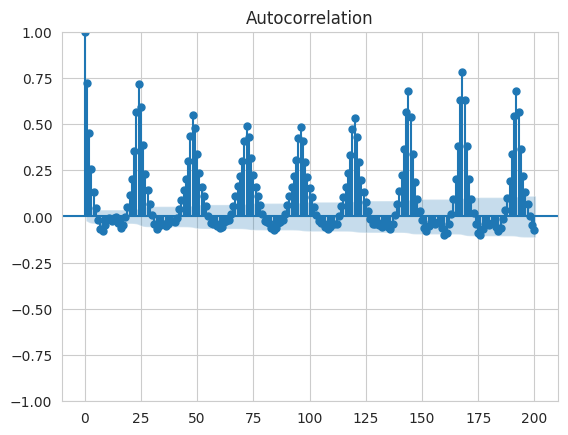

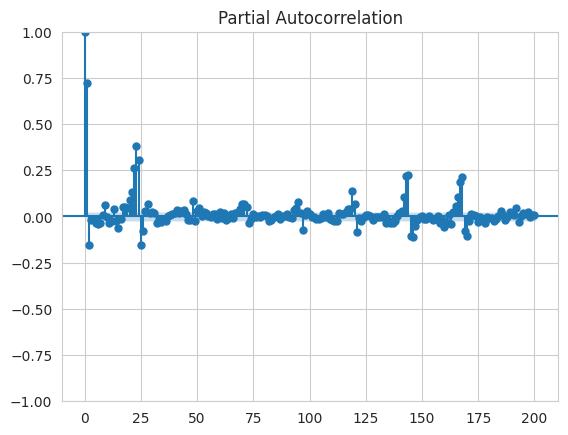

In [19]:
plot_acf(ts_train_31, lags=200)
plot_pacf(ts_train_31, lags=200)
plt.show()

Reasoning in Section 3C

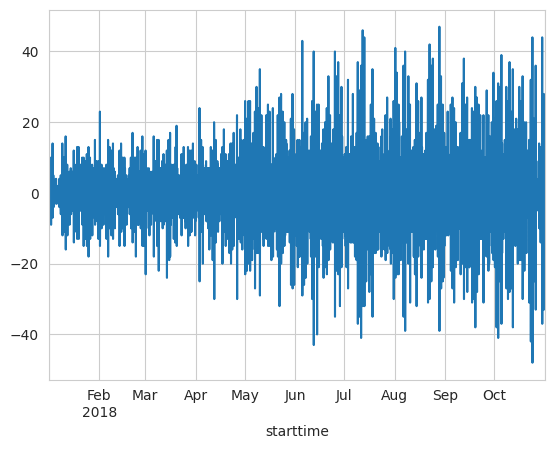

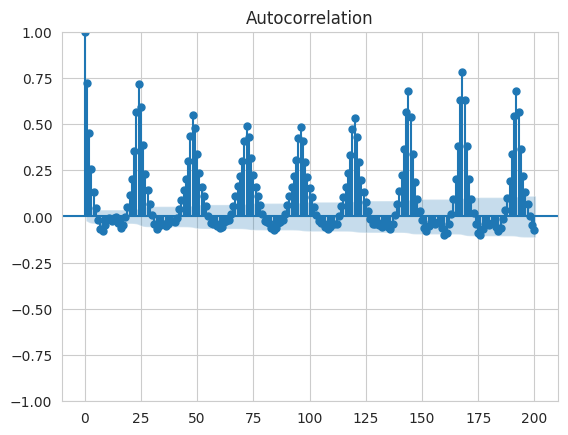

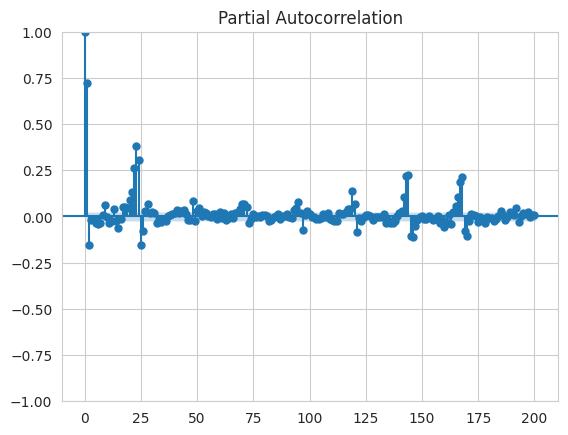

ADF Statistic: -24.557297
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [20]:
#For Lag 1
lag = 1
ts_train_31_lagged = ts_train_31.diff(lag).dropna()
ts_train_31_lagged.plot()
plot_acf(ts_train_31, lags=200)
plot_pacf(ts_train_31, lags=200)
plt.show()
#Dickey-Fuller test
result = adfuller(ts_train_31_lagged)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

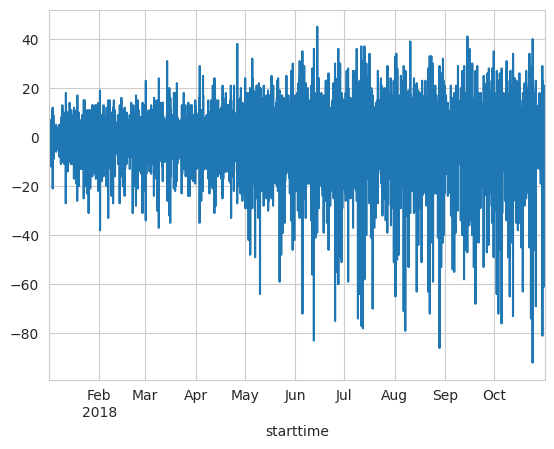

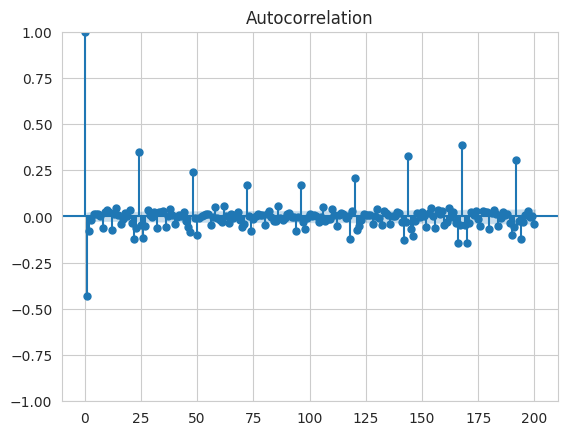

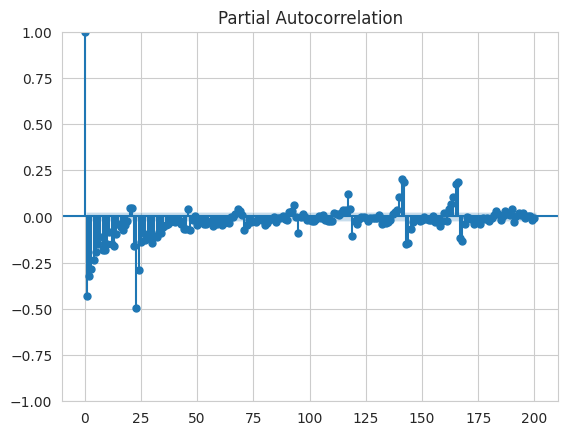

In [21]:
# Second-order difference
lag = 1
ts_train_31_seclag = ts_train_31_lagged.diff(lag).dropna()
ts_train_31_seclag.plot()
plot_acf(ts_train_31_seclag, lags=200)
plot_pacf(ts_train_31_seclag, lags=200)
plt.show()

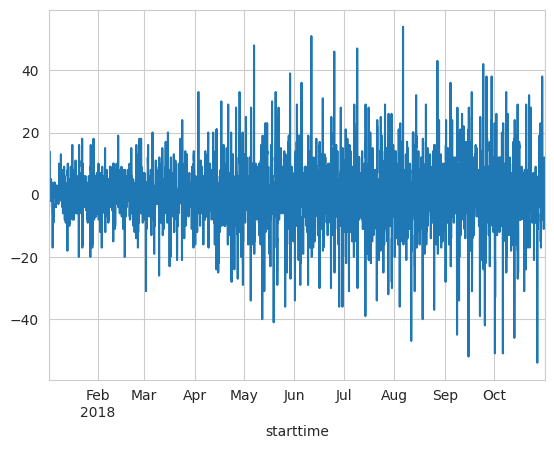

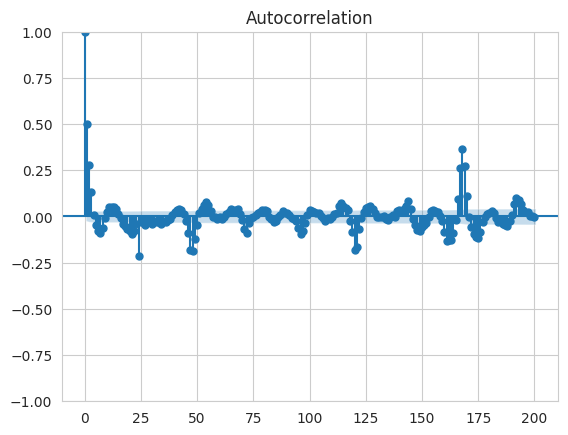

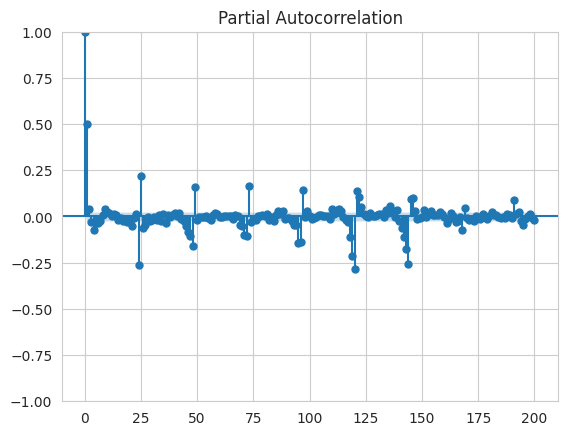

In [22]:
# Seasonal difference (daily)
ts_train_31_lagged_daily = ts_train_31.diff(24).dropna()
ts_train_31_lagged_daily.plot()
plot_acf(ts_train_31_lagged_daily, lags=200)
plot_pacf(ts_train_31_lagged_daily, lags=200)
plt.show()

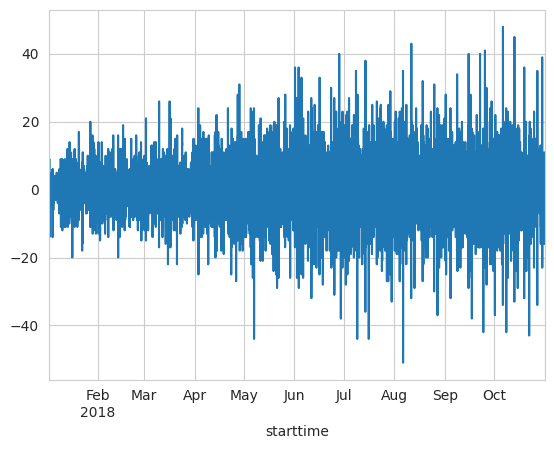

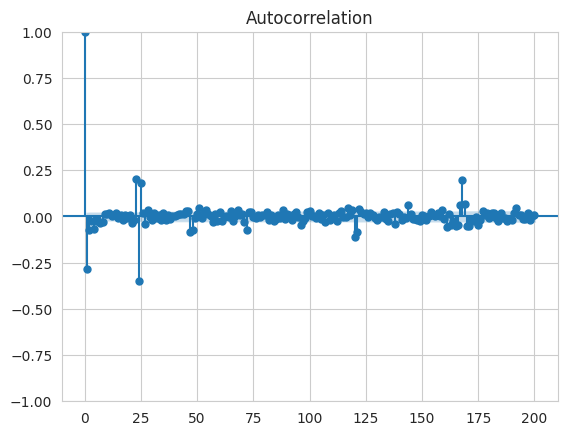

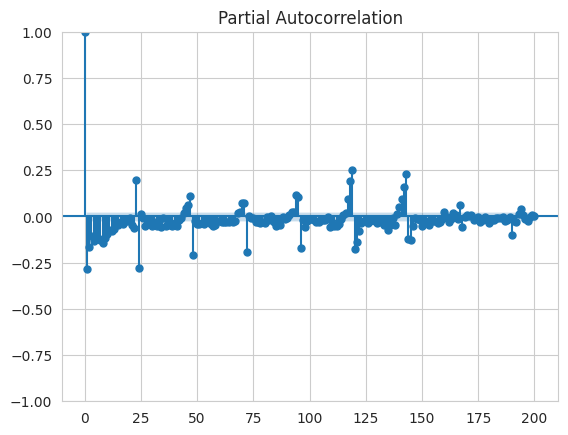

In [23]:
# First daily differencing, then non-seasonal differencing
ts_train_31_lagged_daily_diff = ts_train_31_lagged_daily.diff(1).dropna()
ts_train_31_lagged_daily_diff.plot()
plot_acf(ts_train_31_lagged_daily_diff, lags=200)
plot_pacf(ts_train_31_lagged_daily_diff, lags=200)
plt.show()

### Prediction and Allocation

In [24]:
def moving_average(train, test, index_difference=24, window=1):
    '''
    Computes a moving-average style prediction by averaging multiple lagged values of the
    training and test series. The function aligns past observations spaced by a fixed
    index difference (e.g., 24 hours) and uses their mean as the forecast.

    :param train: Training DataFrame containing a 'Count' column used to compute lagged values.
    :param test: Test DataFrame containing a 'Count' column for which predictions are made.
    :param index_difference: Number of time steps between lagged observations (e.g., 24 for daily seasonality).
    :param window: Number of lagged windows to include in the average (1 → single lag, 2 → two lags, etc.).
    '''
    time_line = pd.concat([train['Count'].tail(index_difference * window), test['Count']]).to_frame()

    predictions = {}
    for w in range(1, window + 1):
        time_line['Lag_{}'.format(w)] = time_line['Count'].shift(index_difference * w)
    
    predictions = time_line[[f'Lag_{w}' for w in range(1, window + 1)]].loc[test.index].mean(axis=1)

    ouput_count_vs_pred  = pd.DataFrame({'count': test['Count'], 'prediction': predictions})

    for idx in test.index:
        lag_values = []
        for w in range(1, window + 1):
            lag_values.append(time_line.loc[idx, 'Lag_{}'.format(w)])
        predictions[idx] = np.mean(lag_values)

    return mean_squared_error(test['Count'], pd.Series(predictions)) / (len(test.index)/24), ouput_count_vs_pred


def find_significant_lags(values, conf_int):
    '''
    Identifies which lag values exceed a given confidence interval threshold.

    :param values: Iterable of correlation or PACF values indexed by lag.
    :param conf_int: Confidence interval threshold; lags exceeding this value in magnitude are kept.
    '''
    significant = []
    for lag, val in enumerate(values):
        if abs(val) > conf_int:
            significant.append(lag)
    return significant

def pick_order(significant_lags):
    '''
    Selects the highest consecutive lag in a run of significant PACF values,
    typically used to determine AR order.

    :param significant_lags: List of lag indices considered statistically significant.
    '''
    value = significant_lags[0]
    for i in range(1, len(significant_lags)):
        if significant_lags[i] == significant_lags[i-1] + 1:
            value = significant_lags[i]
    return max(value, 1)

def custom_pacf_calculation(x:ArrayLike1D, method:str='adjusted', nlags = [168, 168 * 2, 168 * 3, 168 * 4, 168 * 5, 168 * 6, 168 * 7]):
    '''
    Computes partial autocorrelation values using the Yule-Walker method for a list of lag values.

    :param x: 1D array-like input time series.
    :param method: Yule-Walker estimation method ('adjusted' or alternatives supported by statsmodels).
    :param nlags: Iterable of lag values for which PACF should be computed.
    '''
    pacf = [1.0]
    for k in nlags:
        pacf.append(yule_walker(x, k, method=method)[0][-1])
    return np.array(pacf)

def prepare_regression_lagged_features(train, test):
    '''
    Performs linear regression to predict residuals (Lag_Accounted_Count) using PACF-based lag features
    and optionally weather-related predictors. Supports three modes: no weather, raw weather, or
    day/night-split weather effects.

    :param train: Training DataFrame containing count, lagged counts, and possibly weather features.
    :param test: Test DataFrame with the same structure as train.
    :param weather_mode: One of {'exclude', 'include', 'day_night'} determining which weather features are used.
    '''
    pacf_week = custom_pacf_calculation(pd.concat([train, test])['Lag_Accounted_Count'], nlags=range(168, 168*7+1, 168))
    conf_int = 1.96 / np.sqrt(len(train))
    sig_pacf_week = find_significant_lags(pacf_week, conf_int)
    p_week = pick_order(sig_pacf_week)

    df = pd.concat([train, test], axis=0)
  
    for lag in range(1, p_week + 1):
        df['PACF_Lag_{}'.format(lag)] = df['Lag_Accounted_Count'].shift(lag * 168)
    df = df.dropna()
    return df, p_week

def residual_regression(train, test, weather_mode="exclude"):
    '''
    Performs linear regression to predict residuals (Lag_Accounted_Count) using PACF-based lag features
    and optionally weather-related predictors. Supports three modes: no weather, raw weather, or
    day/night-split weather effects.

    :param train: Training DataFrame containing count, lagged counts, and possibly weather features.
    :param test: Test DataFrame with the same structure as train.
    :param weather_mode: One of {'exclude', 'include', 'day_night'} determining which weather features are used.
    '''
    df, p_week = prepare_regression_lagged_features(train, test)

    pacf_features = [f'PACF_Lag_{i}' for i in range(1, p_week + 1)]

    features = pacf_features

    if weather_mode == 'include':
        weather_features = [
            'temperature_2m', 'rain', 'snowfall',
            'wind_speed_10m', 'cloud_cover', 'sunshine_duration'
        ]
        #weather_cols = [c for c in weather_features if c in train.columns]
        weather_cols = [f'{c}_lag_accounted' for c in weather_features if f'{c}_lag_accounted' in df.columns]
        features += weather_cols
    elif weather_mode == 'day_night':
        hours = df.index.hour
        df['is_day'] = ((hours >= 6) & (hours <= 20)).astype(int)

        weather_features = [
            'temperature_2m', 'rain', 'snowfall',
            'wind_speed_10m', 'cloud_cover', 'sunshine_duration'
        ]
       # weather_cols = [c for c in weather_features if c in train.columns]
        weather_cols = [f'{c}_lag_accounted' for c in weather_features if f'{c}_lag_accounted' in df.columns]

        for shifted_col in weather_cols:
            df[f'{shifted_col}_day'] = df[shifted_col] * df['is_day']
            df[f'{shifted_col}_night'] = df[shifted_col] * (1 - df['is_day'])

        day_night_features = []
        for c in weather_cols:
            day_night_features += [f'{c}_day', f'{c}_night']
        
        features += day_night_features

    df_train = df.loc[df.index.intersection(train.index)]
    model = LinearRegression()
    model.fit(df_train[features], df_train['Lag_Accounted_Count'])

    df_test = df.loc[df.index.intersection(test.index)]
    df_test['Lag_Accounted_Count_prediction'] = model.predict(df_test[features])
    mse = mean_squared_error(df_test['Lag_Accounted_Count'], df_test['Lag_Accounted_Count_prediction']) / (len(df_test.index) / 24)
    output_count_vs_pred  = pd.DataFrame({'count': df_test['Count'], 'prediction': df_test['Lag_Accounted_Count_prediction'] + df_test['Lag_Count']})

    return mse, output_count_vs_pred

In [25]:
class StationEvaluator:
    def __init__(self, df_train, df_weather, feature='starttime', differencing=168, use_weather=True):
        '''
        Initializes the StationEvaluator by converting trip data into hourly counts,
        optionally merging weather data, and applying differencing to create lag-adjusted
        features used for forecasting.

        :param df_train: Training DataFrame containing trip records with a datetime column.
        :param df_weather: DataFrame containing hourly weather features indexed by datetime.
        :param feature: Column name in df_train representing the trip start time.
        :param differencing: Number of hours used for seasonal differencing (e.g., 168 for weekly cycles).
        :param use_weather: Whether to include weather features in the evaluation pipeline.
        '''
        self.use_weather = use_weather
        self.df_train_dev = self._prepare_hourly_data(df_train.copy(), feature)
        if use_weather:
            self.df_weather = df_weather.copy()
            self.df_train_dev = self.df_train_dev.join(self.df_weather, how='left')
        if differencing:
            self._difference_data(differencing)

    def _prepare_hourly_data(self, df_train, feature):
        df_train_dev = df_train.set_index(feature)
        df_train_dev = df_train_dev.resample('h').size().rename('Count')
    
        return df_train_dev.to_frame()


    def _difference_data(self, differencing):
        self.df_train_dev['Lag_Count'] = self.df_train_dev['Count'].shift(differencing)
        self.df_train_dev['Lag_Accounted_Count'] = self.df_train_dev['Count'] - self.df_train_dev['Lag_Count']

        # difference weather data, not taking into account day and night
        if self.use_weather:
            weather_cols = [c for c in self.df_weather.columns if c in self.df_train_dev.columns] # if we want to include all columns

            for col in weather_cols:
                self.df_train_dev[f'{col}_lag'] = self.df_train_dev[col].shift(differencing)
                self.df_train_dev[f'{col}_lag_accounted'] = self.df_train_dev[col] - self.df_train_dev[f'{col}_lag']

        self.df_train_dev = self.df_train_dev.dropna()


    def _run_cv_evaluation(self):
        days_2017 = self.df_train_dev[self.df_train_dev.index < pd.to_datetime('2018-01-01')].index.date
        unique_days_2017 = pd.Series(days_2017).drop_duplicates().reset_index(drop=True)

        days_2018 = self.df_train_dev[self.df_train_dev.index >= pd.to_datetime('2018-01-01')].index.date
        unique_days_2018 = pd.Series(days_2018).drop_duplicates().reset_index(drop=True)
        
        n_splits = 5
        tscv = TimeSeriesSplit(n_splits=n_splits) # change this to split only form 2018-01-01 to 2018-10-31
        

        
        performance_df = pd.DataFrame(columns=['Fold', 'Method', 'Window', 'Index Difference', 'MSE'])
        
        for fold_num, (train_day_idx, test_day_idx) in enumerate(tscv.split(unique_days_2018)):
            # correct the indexes here

            train_days = pd.concat([pd.to_datetime(unique_days_2017), pd.to_datetime(unique_days_2018[train_day_idx])])
            validation_days  = pd.to_datetime(unique_days_2018[test_day_idx])
            train_idx = self.df_train_dev.index.floor('D').isin(train_days)
            validation_idx  = self.df_train_dev.index.floor('D').isin(validation_days)
            
            X_train = self.df_train_dev[train_idx]
            X_test  = self.df_train_dev[validation_idx]

            mse, _  = moving_average(X_train, X_test, index_difference=24, window=1)
            performance_df= add_row(performance_df,
                                    {'Fold': fold_num, 'Method': 'Day by Day', 'Window': 1, 'Index Difference': 24, 'MSE': mse})

            mse, _ = moving_average(X_train, X_test, index_difference=24, window=7)
            performance_df= add_row(performance_df,
                                    {'Fold': fold_num, 'Method': 'Day by Day', 'Window': 7, 'Index Difference': 24, 'MSE': mse})

            mse, _ = moving_average(X_train, X_test, index_difference=168, window=1)
            performance_df = add_row(performance_df,
                                    {'Fold': fold_num, 'Method': 'Week by Week', 'Window': 1, 'Index Difference': 168, 'MSE': mse})

            mse, _ = moving_average(X_train, X_test, index_difference=168, window=4)
            performance_df = add_row(performance_df,
                                    {'Fold': fold_num, 'Method': 'Week by Week', 'Window': 4, 'Index Difference': 168, 'MSE': mse})

            mse, _ = residual_regression(X_train, X_test)
            performance_df = add_row(performance_df,
                                    {'Fold': fold_num, 'Method': 'Residual Regression', 'Window': 'N/A', 'Index Difference': 'N/A', 'MSE': mse})
            
            if self.use_weather:
                mse, _ = residual_regression(X_train, X_test, weather_mode='include')
                performance_df = add_row(performance_df,
                                        {'Fold': fold_num, 'Method': 'Residual Regression with weather data', 'Window': 'N/A', 'Index Difference': 'N/A', 'MSE': mse})
                mse, _ = residual_regression(X_train, X_test, weather_mode='day_night')
                performance_df = add_row(performance_df,
                                        {'Fold': fold_num, 'Method': 'Residual Regression (weather and day/night)', 'Window': 'N/A', 'Index Difference': 'N/A', 'MSE': mse})
                
        return performance_df

    def evaluate_predictors(self):
        '''
        Evaluates all predictor methods by aggregating cross-validation results,
        returning mean and standard deviation of MSE for each method and configuration.

        :return: Summary DataFrame with average and standard deviation MSE grouped by predictor method.
        '''
        performance_df = self._run_cv_evaluation()

        summary_df = performance_df.groupby(['Method', 'Window', 'Index Difference']).agg(
            Mean_MSE=('MSE', 'mean'),
            Std_MSE=('MSE', 'std')
        ).reset_index()

        return summary_df


In [26]:
class AllocationPredictor:
    def __init__(self, train_pickups, test_pickups, train_dropoffs, test_dropoffs, results_pickups, results_dropoffs, df_weather=None, differencing=168):
        '''
        Initializes the AllocationPredictor by selecting the best-performing models for pickups
        and dropoffs, preparing hourly count data, applying differencing for lag features, 
        and computing confidence intervals for cumulative errors.

        :param train_pickups: DataFrame of training pickup events with 'starttime' column.
        :param test_pickups: DataFrame of test pickup events with 'starttime' column.
        :param train_dropoffs: DataFrame of training dropoff events with 'stoptime' column.
        :param test_dropoffs: DataFrame of test dropoff events with 'stoptime' column.
        :param results_pickups: DataFrame summarizing model performance for pickups (used to select best model).
        :param results_dropoffs: DataFrame summarizing model performance for dropoffs (used to select best model).
        :param df_weather: Optional DataFrame with hourly weather features.
        :param differencing: Number of hours used for seasonal differencing (default 168 hours, one week).
        '''
        self.best_pickups = self._find_best_model(results_pickups)
        self.best_dropoffs = self._find_best_model(results_dropoffs)
        print(self.best_pickups)
        print(self.best_dropoffs)
        self.df_weather = df_weather.copy() if df_weather is not None else None
    
        self.df_train_dev_pickups, self.df_train_dev_dropoffs = self._prepare_hourly_data(train_pickups.copy(), train_dropoffs.copy(), self.df_weather)
        self.df_test_dev_pickups, self.df_test_dev_dropoffs = self._prepare_hourly_data(test_pickups.copy(), test_dropoffs.copy(), self.df_weather)
        if differencing:
            self._difference(differencing)

        self.confidence_interval = self._find_confidence_intervals()
    
    def _prepare_hourly_data(self, df_pickups, df_dropoffs, df_weather):
        df_pickups = (
            df_pickups.set_index('starttime')
                .resample('h').size()
                .rename('Count')
        )
        df_dropoffs = (
            df_dropoffs.set_index('stoptime')
                .resample('h').size()
                .rename('Count')
        )

        start = min(df_dropoffs.index.min(), df_pickups.index.min())
        end   = max(df_dropoffs.index.max(), df_pickups.index.max())
    
        # this is nessesary to ensure no gap between train and test, if no dropoffs at hour 0 for november
        start = start.normalize()
        end   = (end + pd.Timedelta(days=1)).normalize() - pd.Timedelta(hours=1)
        common_index = pd.date_range(start=start, end=end, freq='h')

        df_dropoffs = df_dropoffs.reindex(common_index, fill_value=0).to_frame()
        df_pickups = df_pickups.reindex(common_index, fill_value=0).to_frame()
        if df_weather is not None:
            df_dropoffs = df_dropoffs.join(df_weather, how='left')
            df_pickups = df_pickups.join(df_weather, how='left')

        return df_pickups, df_dropoffs

    def _difference(self, differencing):
        self.df_train_dev_pickups = self._difference_data(self.df_train_dev_pickups, differencing)
        self.df_train_dev_dropoffs = self._difference_data(self.df_train_dev_dropoffs, differencing)

        self.df_test_dev_pickups = self._difference_data(self.df_test_dev_pickups, differencing)
        self.df_test_dev_dropoffs = self._difference_data(self.df_test_dev_dropoffs, differencing)

        
    def _difference_data(self, df, differencing):
        df['Lag_Count'] = df['Count'].shift(differencing)
        df['Lag_Accounted_Count'] = df['Count'] - df['Lag_Count']

        # difference weather data, not taking into account day and night
        if self.df_weather is not None:
            weather_cols = self.df_weather.columns
            for col in weather_cols:
                df[f'{col}_lag'] = df[col].shift(differencing)
                df[f'{col}_lag_accounted'] = df[col] - df[f'{col}_lag']
        df = df.dropna()
        return df


    def _find_best_model(self, results):
        best_row = results.loc[results['Mean_MSE'].idxmin()]
        method = best_row['Method']
        window = best_row['Window']
        index_difference = best_row['Index Difference']

        return {
            'method': method,
            'window': window,
            'index_difference': index_difference
        }
    
    def _predict(self, method_info, df_train, df_test):
        method = method_info['method']
        window = method_info['window']
        index_difference = method_info['index_difference']  

        if method == 'Day by Day' or method == 'Week by Week':
            _, predictions  = moving_average(df_train, df_test, index_difference=index_difference, window=window)
        elif method == 'Residual Regression':
            _, predictions = residual_regression(df_train, df_test)
        elif method == 'Residual Regression with weather data':
            _, predictions = residual_regression(df_train, df_test, weather_mode='include')
        elif method == 'Residual Regression (weather and day/night)':
            _, predictions = residual_regression(df_train, df_test, weather_mode='day_night')
        else:
            raise ValueError(f"Unknown method: {method}")
        return predictions
    
    def _predict_cummulative_pickups_dropoffs(self, df_train_pickups, df_test_pickups, df_train_dropoffs, df_test_dropoffs):
        preds_pickups = self._predict(self.best_pickups, df_train_pickups, df_test_pickups)
        preds_dropoffs = self._predict(self.best_dropoffs, df_train_dropoffs, df_test_dropoffs)

        preds_pickups['cumsum_actual'] = preds_pickups.groupby(preds_pickups.index.date)['count'].cumsum()
        preds_dropoffs['cumsum_actual'] = preds_dropoffs.groupby(preds_dropoffs.index.date)['count'].cumsum()

        # shift dropoffs by 1 hour and then difference to prevent pickups early in hour and dropoffs late in hour to cancel each other out
        dropoffs_shifted = preds_dropoffs.groupby(preds_dropoffs.index.date)['cumsum_actual'].shift(1)
        cummulative_comsum = preds_pickups['cumsum_actual'] - dropoffs_shifted.fillna(0)


        preds_pickups['cumsum_pred'] = preds_pickups.groupby(preds_pickups.index.date)['prediction'].cumsum()
        preds_dropoffs['cumsum_pred'] = preds_dropoffs.groupby(preds_dropoffs.index.date)['prediction'].cumsum()

        dropoffs_shifted = preds_dropoffs.groupby(preds_dropoffs.index.date)['cumsum_pred'].shift(1)
        cummulative_comsum_pred = preds_pickups['cumsum_pred'] - dropoffs_shifted.fillna(0)

        df_cummulative = pd.DataFrame({
            'cumsum_actual': cummulative_comsum,
            'cumsum_pred': cummulative_comsum_pred
        })
        return df_cummulative
        

    def _find_confidence_intervals(self):
        days = self.df_train_dev_pickups.index.date
        
        unique_days = pd.Series(days).drop_duplicates().reset_index(drop=True)
        n_splits = 5
        tscv = TimeSeriesSplit(n_splits=n_splits)

        confidence_intervals_df = pd.DataFrame(columns=["Fold", "Hour", "var", "mean", "95_pc", "99_pc"])

        for fold_num, (train_day_idx, test_day_idx) in enumerate(tscv.split(unique_days)):

            train_days = pd.to_datetime(unique_days[train_day_idx])
            validation_days  = pd.to_datetime(unique_days[test_day_idx])

            train_idx = self.df_train_dev_pickups.index.floor('D').isin(train_days)
            validation_idx  = self.df_train_dev_pickups.index.floor('D').isin(validation_days)

            cummulative_df = self._predict_cummulative_pickups_dropoffs(
                self.df_train_dev_pickups[train_idx],
                self.df_train_dev_pickups[validation_idx],
                self.df_train_dev_dropoffs[train_idx],
                self.df_train_dev_dropoffs[validation_idx]
            )

            errors = cummulative_df['cumsum_actual'] - cummulative_df['cumsum_pred']

            for hour in range(24):
                hour_errors = errors[cummulative_df.index.hour == hour]
                var = np.var(hour_errors)
                mean = np.mean(hour_errors)
                pc_01 = np.percentile(hour_errors, 1)
                pc_05 = np.percentile(hour_errors, 5)
                pc_15 = np.percentile(hour_errors, 15)

                pc_85 = np.percentile(hour_errors, 85)
                pc_95 = np.percentile(hour_errors, 95)
                pc_99 = np.percentile(hour_errors, 99)

                confidence_intervals_df = add_row(confidence_intervals_df, {
                    "Fold": fold_num,
                    "Hour": hour,
                    "var": var,
                    "mean": mean,
                    "01_pc": pc_01,
                    "05_pc": pc_05,
                    "15_pc": pc_15,
                    "85_pc": pc_85,
                    "95_pc": pc_95,
                    "99_pc": pc_99
                })
        
        fold_mean_df = confidence_intervals_df.groupby("Hour").agg({
            "var": "mean",
            "mean": "mean",
            "01_pc": "mean",
            "05_pc": "mean",
            "15_pc": "mean",
            "85_pc": "mean",
            "95_pc": "mean",
            "99_pc": "mean"
        }).reset_index()
        
        return fold_mean_df

    def _predict_allocation(self):
        allocation_df = self._predict_cummulative_pickups_dropoffs(
            self.df_train_dev_pickups,
            self.df_test_dev_pickups,
            self.df_train_dev_dropoffs,
            self.df_test_dev_dropoffs
        )

        allocation_df["Hour"] = allocation_df.index.hour

        allocation_df = allocation_df.merge(self.confidence_interval, on='Hour', how='left').set_index(allocation_df.index)
        allocation_df['allocation_99_pc_by_hour'] = allocation_df['cumsum_pred'] + allocation_df['99_pc']
        
        allocation_df['allocation_99_pc'] = allocation_df.groupby(allocation_df.index.date)['allocation_99_pc_by_hour'].transform('max')
        return allocation_df[['cumsum_actual', 'cumsum_pred', 'allocation_99_pc', 'allocation_99_pc_by_hour']]

    def evaluate_predict_allocation(self):
        '''
        Evaluates the allocation predictions by computing the daily coverage rate, i.e., the
        fraction of days where the predicted allocation meets or exceeds the actual net demand.

        :return: Dictionary containing per-day allocation errors and overall daily coverage.
        '''
        allocation_df = self._predict_allocation()

        allocation_df['error_99_pc'] = allocation_df['allocation_99_pc'] - allocation_df['cumsum_actual']

        day_min_error = allocation_df.groupby(allocation_df.index.date)['error_99_pc'].min()
        days_under = day_min_error < 0
        daily_coverage = 1.0 - (days_under.sum() / len(day_min_error))

        return {
            'error': day_min_error,
            'daily_coverage': daily_coverage,
        }

In [27]:
def evaluate_model_performance(df_train_pickups, df_test_pickups, df_train_dropoffs, df_test_dropoffs, df_weather=None, include_weather=False):
    '''
    Evaluates the performance of pickup and dropoff prediction models for each cluster
    by running cross-validation on StationEvaluator and AllocationPredictor. Optionally
    includes weather features in the evaluation.

    :param df_train_pickups: Training DataFrame of pickup events with 'start_centroid' and 'starttime'.
    :param df_test_pickups: Test DataFrame of pickup events with 'start_centroid' and 'starttime'.
    :param df_train_dropoffs: Training DataFrame of dropoff events with 'end_centroid' and 'stoptime'.
    :param df_test_dropoffs: Test DataFrame of dropoff events with 'end_centroid' and 'stoptime'.
    :param df_weather: Optional DataFrame containing weather features for inclusion in the models.
    :param include_weather: Boolean flag to indicate whether weather features should be used in evaluations.
    :return: List of dictionaries, each containing allocation errors and daily coverage for a cluster.
    '''
    performance = []
    for cluster in df_train_pickups.start_centroid.unique():
        sp_pickup = StationEvaluator(df_train_pickups[df_train_pickups['start_centroid'] == cluster], df_weather, use_weather=include_weather)
        eval_pickup = sp_pickup.evaluate_predictors()

        sp_dropoff = StationEvaluator(df_train_dropoffs[df_train_dropoffs['end_centroid'] == cluster],  df_weather, feature='stoptime', use_weather=include_weather)
        eval_dropoff = sp_dropoff.evaluate_predictors()

        ap = AllocationPredictor(
            df_train_pickups[df_train_pickups['start_centroid'] == cluster],
            df_test_pickups[df_test_pickups['start_centroid'] == cluster],
            df_train_dropoffs[df_train_dropoffs['end_centroid'] == cluster],
            df_test_dropoffs[df_test_dropoffs['end_centroid'] == cluster],
            eval_pickup,
            eval_dropoff, 
            df_weather)
        allocation_performance = ap.evaluate_predict_allocation()
        performance.append(allocation_performance)
    return performance

In [28]:
df = pd.read_csv('data/Trips_2018.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.dropna(subset=['start_station_id'])
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

In [29]:
df_train_pickups, df_test_pickups = df[(df['starttime'].dt.month < 11) & (df['starttime'].dt.year == 2018)].copy(), df[(df['starttime'].dt.month >= 11) & (df['starttime'].dt.year == 2018)].copy()
df_train_dropoffs, df_test_dropoffs = df[(df['stoptime'].dt.month < 11) & (df['stoptime'].dt.year == 2018)].copy(), df[(df['stoptime'].dt.month >= 11) & (df['stoptime'].dt.year == 2018)].copy()

In [30]:
df_unique_start_stations = df_train_pickups[['start_station_id', 'start_station_latitude', 'start_station_longitude']].drop_duplicates().reset_index()
df_unique_start_stations = df_unique_start_stations.dropna()
df_unique_start_stations = df_unique_start_stations.drop(columns=['index'])
df_unique_start_stations = df_unique_start_stations[~(df_unique_start_stations['start_station_latitude'] > 45)]

In [31]:
K = 32

KMeans_model = KMeans(n_clusters=K, random_state=1711).fit(df_unique_start_stations[['start_station_latitude', 'start_station_longitude']])
df_unique_start_stations['cluster'] = KMeans_model.labels_
df_unique_start_stations

start_station_id  start_station_latitude  start_station_longitude  \
0                72.0               40.767272               -73.993929   
1                79.0               40.719116               -74.006667   
2                82.0               40.711174               -74.000165   
3                83.0               40.683826               -73.976323   
4               119.0               40.696089               -73.978034   
..                ...                     ...                      ...   
806            3630.0               40.803865               -73.955931   
807            3154.0               40.773142               -73.958562   
808            3709.0               40.738046               -73.996430   
809            3711.0               40.729667               -73.980680   
810            3712.0               40.754692               -73.997402   

     cluster  
0         31  
1         21  
2          3  
3          9  
4         28  
..       ...  
806       10  
807       11  
808       25  
809       12  
810        8  

[809 rows x 4 columns]

In [32]:
station_to_cluster = (
    df_unique_start_stations
    .drop_duplicates(subset='start_station_id')
    .set_index('start_station_id')['cluster']
)

In [33]:
df_train_pickups['start_centroid'] = df_train_pickups['start_station_id'].map(station_to_cluster)
df_train_dropoffs['end_centroid'] = df_train_dropoffs['end_station_id'].map(station_to_cluster)

df_train_pickups = df_train_pickups.dropna(subset=['start_centroid'])
df_train_dropoffs = df_train_dropoffs.dropna(subset=['end_centroid'])

df_test_pickups['start_centroid'] = df_test_pickups['start_station_id'].map(station_to_cluster)
df_test_dropoffs['end_centroid'] = df_test_dropoffs['end_station_id'].map(station_to_cluster)

df_test_pickups = df_test_pickups.dropna(subset=['start_centroid'])
df_test_dropoffs = df_test_dropoffs.dropna(subset=['end_centroid'])

In [34]:
performance = evaluate_model_performance(df_train_pickups, df_test_pickups, df_train_dropoffs, df_test_dropoffs, df_weather=None, include_weather=False)

{'method': 'Week by Week', 'window': 4, 'index_difference': 168}
{'method': 'Week by Week', 'window': 4, 'index_difference': 168}
{'method': 'Week by Week', 'window': 4, 'index_difference': 168}
{'method': 'Week by Week', 'window': 4, 'index_difference': 168}
{'method': 'Week by Week', 'window': 4, 'index_difference': 168}
{'method': 'Week by Week', 'window': 4, 'index_difference': 168}
{'method': 'Residual Regression', 'window': 'N/A', 'index_difference': 'N/A'}
{'method': 'Week by Week', 'window': 4, 'index_difference': 168}
{'method': 'Residual Regression', 'window': 'N/A', 'index_difference': 'N/A'}
{'method': 'Week by Week', 'window': 4, 'index_difference': 168}
{'method': 'Week by Week', 'window': 4, 'index_difference': 168}
{'method': 'Week by Week', 'window': 4, 'index_difference': 168}
{'method': 'Week by Week', 'window': 4, 'index_difference': 168}
{'method': 'Week by Week', 'window': 4, 'index_difference': 168}
{'method': 'Week by Week', 'window': 4, 'index_difference': 168}

In [35]:
concated_error = None
coverage_rates = []
for perf in performance:
    if concated_error is None:
        concated_error = perf['error']
    else:
        concated_error = pd.concat([concated_error, perf['error']])
    coverage_rates.append(perf['daily_coverage'])

concated_error.values

sum_neg = concated_error[concated_error < 0].sum() 
sum_pos = concated_error[concated_error > 0].sum() 

mean_neg = concated_error[concated_error < 0].mean() 
mean_pos = concated_error[concated_error > 0].mean() 

print("Sum of the negative concated errors/underestimation of demand:", sum_neg)
print("Sum of the positive concated errors/overestimation of demand:", sum_pos)
print("mean of the negative concated errors/underestimation of demand:",mean_neg )
print("mean of the positive concated errors/overestimation of demand:", mean_pos)

print("mean daily_coverage rate:", np.mean(coverage_rates))
print("std daily_coverage rate:", np.std(coverage_rates))


Sum of the negative concated errors/underestimation of demand: -478.04737581963076
Sum of the positive concated errors/overestimation of demand: 331606.484228662
mean of the negative concated errors/underestimation of demand: -28.120433871742986
mean of the positive concated errors/overestimation of demand: 193.8085822493641
mean daily_coverage rate: 0.990162037037037
std daily_coverage rate: 0.01907967768730849


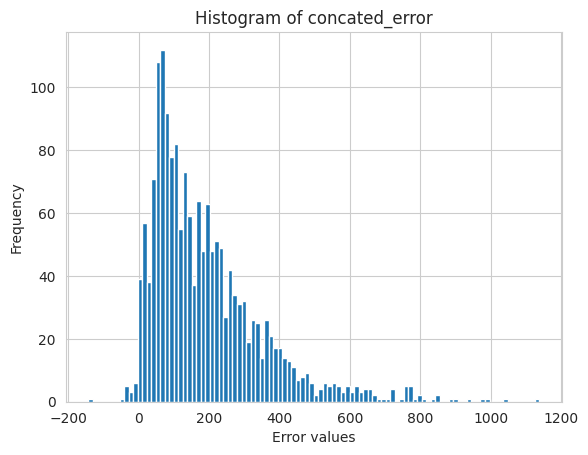

In [36]:
plt.hist(concated_error.values, bins=100)
plt.xlabel("Error values")
plt.ylabel("Frequency")
plt.title("Histogram of concated_error")
plt.show()

## Exploratory Component

In [37]:
read_in_columns_as = ['tripduration', 'starttime', 'stoptime',
       'start_station_id','start_station_name', 'start_station_latitude', 'start_station_longitude',
       'end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude',
       'bikeid', 'usertype', 'birth_year', 'gender']
select_columns = ['tripduration', 'starttime', 'stoptime',
       'start_station_id', 'start_station_latitude', 'start_station_longitude',
       'end_station_id', 'end_station_latitude', 'end_station_longitude',
       'bikeid', 'usertype', 'birth_year', 'gender']

if not os.path.isfile('data/Trips_2017.csv'):
    data_dir = 'data/2017-citibike-tripdata'
    if not os.path.exists(data_dir):
        url = 'https://s3.amazonaws.com/tripdata/2017-citibike-tripdata.zip'
        zip_path = 'data/2017-citibike-tripdata.zip'
        urllib.request.urlretrieve(url, zip_path)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall('data')

        os.remove(zip_path)

    all_files = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.csv'):
                all_files.append(os.path.join(root, file))
    df_for_contact = []
    for file in all_files:
        tmp_df = pd.read_csv(file)
        tmp_df.columns = read_in_columns_as
        df_for_contact.append(tmp_df)
    df_2017 = pd.concat(df_for_contact, ignore_index=True)
    df_2017 = df_2017[select_columns]
    df_2017.to_csv('data/Trips_2017.csv')
    del df_for_contact

In [38]:
df = pd.read_csv('data/Trips_2018.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df.dropna(subset=['start_station_id'])
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

In [39]:
df_train_pickups, df_test_pickups = df[(df['starttime'].dt.month < 11) & (df['starttime'].dt.year == 2018)].copy(), df[(df['starttime'].dt.month >= 11) & (df['starttime'].dt.year == 2018)].copy()
df_train_dropoffs, df_test_dropoffs = df[(df['stoptime'].dt.month < 11) & (df['stoptime'].dt.year == 2018)].copy(), df[(df['stoptime'].dt.month >= 11) & (df['stoptime'].dt.year == 2018)].copy()

In [40]:
df_2017 = pd.read_csv('data/Trips_2017.csv')

df_2017 = df_2017.dropna(subset=['start_station_id'])
df_2017['starttime'] = pd.to_datetime(df_2017['starttime'])
df_2017['stoptime'] = pd.to_datetime(df_2017['stoptime'])

df_train_pickups = pd.concat([df_2017, df_train_pickups], ignore_index=True)
df_train_dropoffs = pd.concat([df_2017, df_train_dropoffs], ignore_index=True)

del df_2017

In [41]:
df_train_pickups['start_centroid'] = df_train_pickups['start_station_id'].map(station_to_cluster)
df_train_dropoffs['end_centroid'] = df_train_dropoffs['end_station_id'].map(station_to_cluster)

df_train_pickups = df_train_pickups.dropna(subset=['start_centroid'])
df_train_dropoffs = df_train_dropoffs.dropna(subset=['end_centroid'])

df_test_pickups['start_centroid'] = df_test_pickups['start_station_id'].map(station_to_cluster)
df_test_dropoffs['end_centroid'] = df_test_dropoffs['end_station_id'].map(station_to_cluster)

df_test_pickups = df_test_pickups.dropna(subset=['start_centroid'])
df_test_dropoffs = df_test_dropoffs.dropna(subset=['end_centroid'])

In [42]:
lat, lon = 40.7128, -74.0060

start = "2017-01-01"
end   = "2018-12-31"

hourly_vars = ",".join(["temperature_2m","dew_point_2m", "precipitation","rain","snowfall","snow_depth","pressure_msl","cloud_cover","wind_speed_10m","wind_direction_10m","wind_gusts_10m","sunshine_duration"])

url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={lat}&longitude={lon}"
    f"&start_date={start}&end_date={end}"
    f"&hourly={hourly_vars}"
    f"&timezone=America%2FNew_York"
)

r = requests.get(url)
r.raise_for_status()
data = r.json()

df_weather = pd.DataFrame(data["hourly"])
df_weather["time"] = pd.to_datetime(df_weather["time"])
df_weather.set_index("time", inplace=True)
df_weather

temperature_2m  dew_point_2m  precipitation  rain  \
time                                                                     
2017-01-01 00:00:00             5.7          -4.3            0.0   0.0   
2017-01-01 01:00:00             5.8          -3.8            0.1   0.1   
2017-01-01 02:00:00             5.3          -3.0            0.0   0.0   
2017-01-01 03:00:00             5.4          -3.0            0.0   0.0   
2017-01-01 04:00:00             4.7          -3.1            0.0   0.0   
...                             ...           ...            ...   ...   
2018-12-31 19:00:00             5.4           4.7            4.1   4.1   
2018-12-31 20:00:00             6.1           5.3            2.6   2.6   
2018-12-31 21:00:00             6.5           5.7            3.4   3.4   
2018-12-31 22:00:00             7.1           6.3            3.9   3.9   
2018-12-31 23:00:00             8.0           7.3            4.6   4.6   

                     snowfall  snow_depth  pressure_msl  cloud_cover  \
time                                                                   
2017-01-01 00:00:00       0.0         0.0        1012.5           99   
2017-01-01 01:00:00       0.0         0.0        1012.8           97   
2017-01-01 02:00:00       0.0         0.0        1013.0           88   
2017-01-01 03:00:00       0.0         0.0        1013.3           49   
2017-01-01 04:00:00       0.0         0.0        1013.7            0   
...                       ...         ...           ...          ...   
2018-12-31 19:00:00       0.0         0.0        1020.5          100   
2018-12-31 20:00:00       0.0         0.0        1018.6          100   
2018-12-31 21:00:00       0.0         0.0        1016.5          100   
2018-12-31 22:00:00       0.0         0.0        1013.6          100   
2018-12-31 23:00:00       0.0         0.0        1011.3          100   

                     wind_speed_10m  wind_direction_10m  wind_gusts_10m  \
time                                                                      
2017-01-01 00:00:00            22.5                 221            36.4   
2017-01-01 01:00:00            23.1                 233            37.8   
2017-01-01 02:00:00            19.5                 232            37.4   
2017-01-01 03:00:00            19.4                 239            32.4   
2017-01-01 04:00:00            19.0                 243            31.7   
...                             ...                 ...             ...   
2018-12-31 19:00:00            17.1                 129            37.1   
2018-12-31 20:00:00            20.7                 129            33.5   
2018-12-31 21:00:00            23.3                 129            38.5   
2018-12-31 22:00:00            26.3                 131            43.2   
2018-12-31 23:00:00            20.1                 136            43.6   

                     sunshine_duration  
time                                    
2017-01-01 00:00:00                0.0  
2017-01-01 01:00:00                0.0  
2017-01-01 02:00:00                0.0  
2017-01-01 03:00:00                0.0  
2017-01-01 04:00:00                0.0  
...                                ...  
2018-12-31 19:00:00                0.0  
2018-12-31 20:00:00                0.0  
2018-12-31 21:00:00                0.0  
2018-12-31 22:00:00                0.0  
2018-12-31 23:00:00                0.0  

[17520 rows x 12 columns]

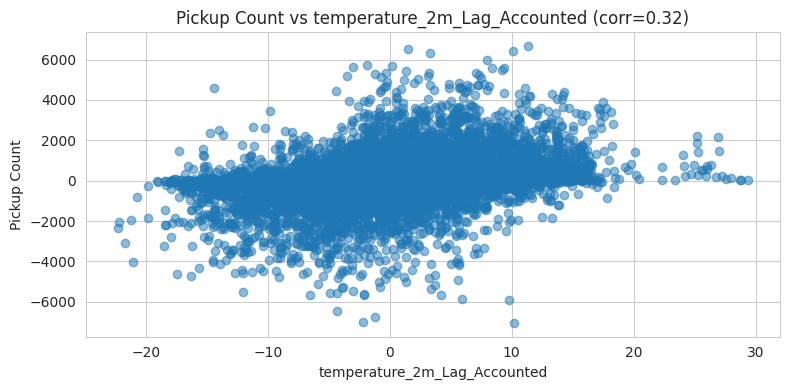

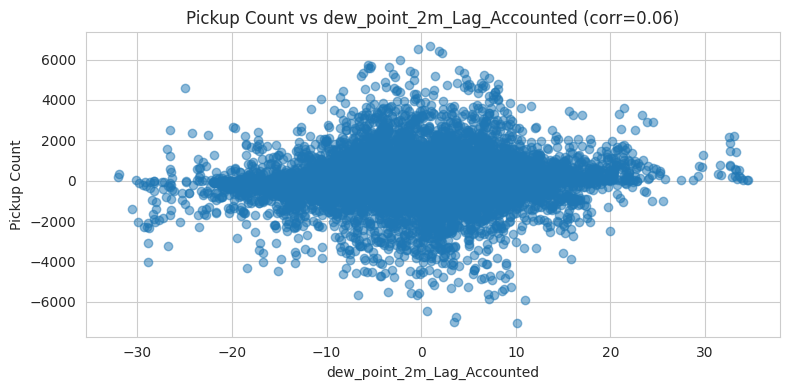

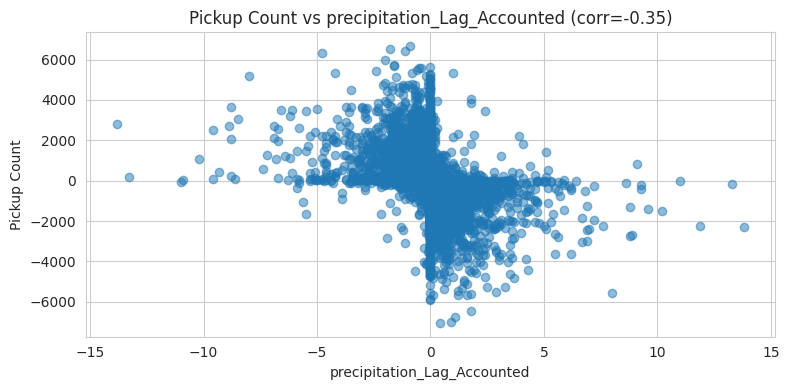

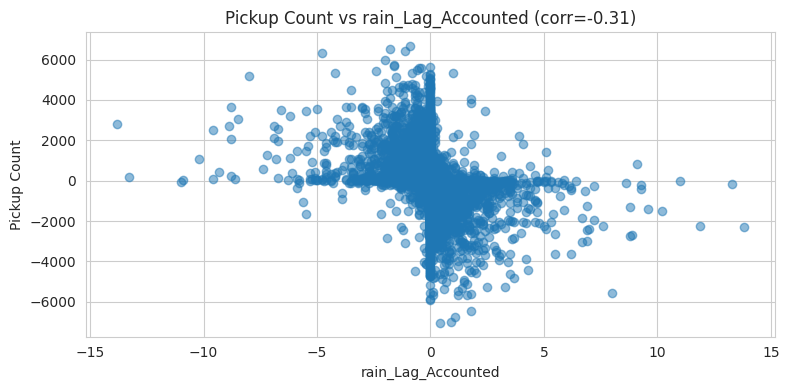

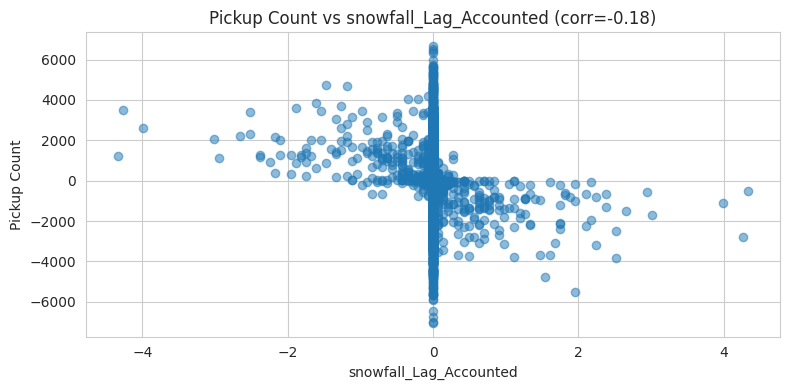

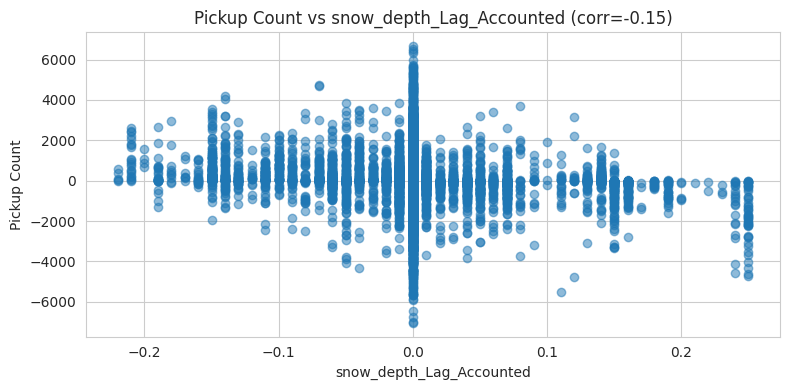

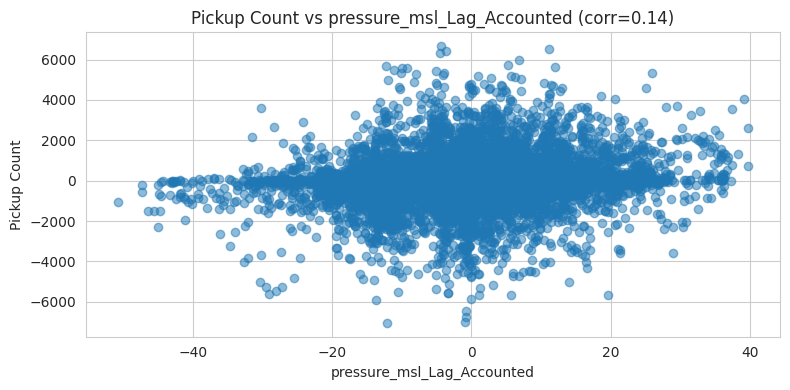

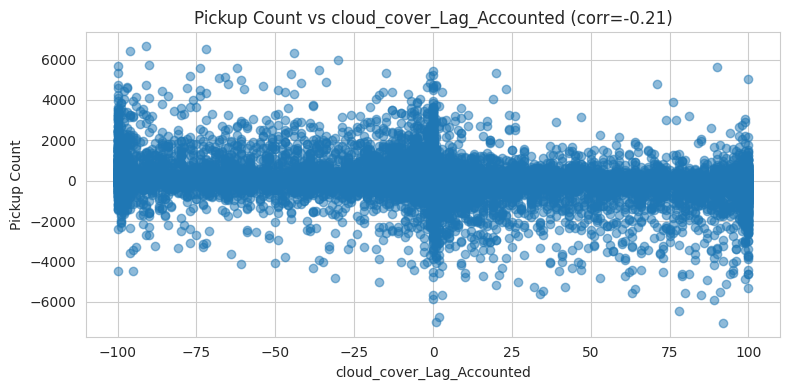

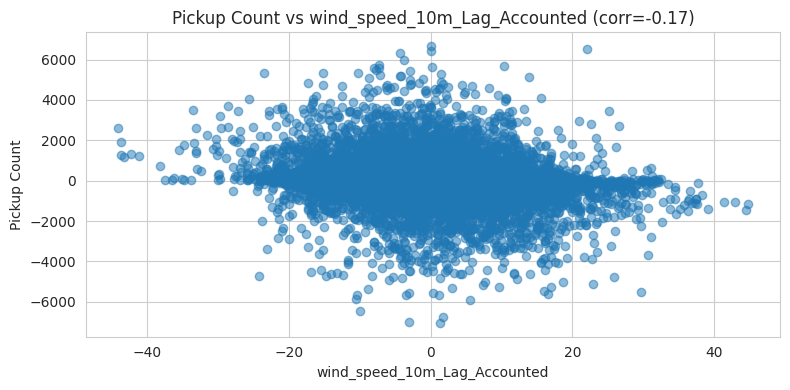

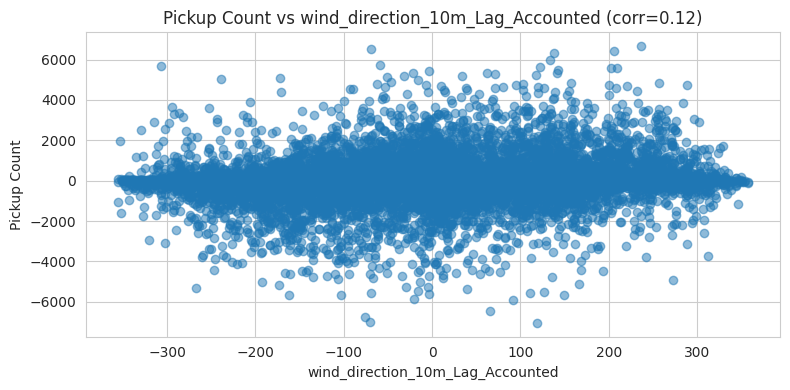

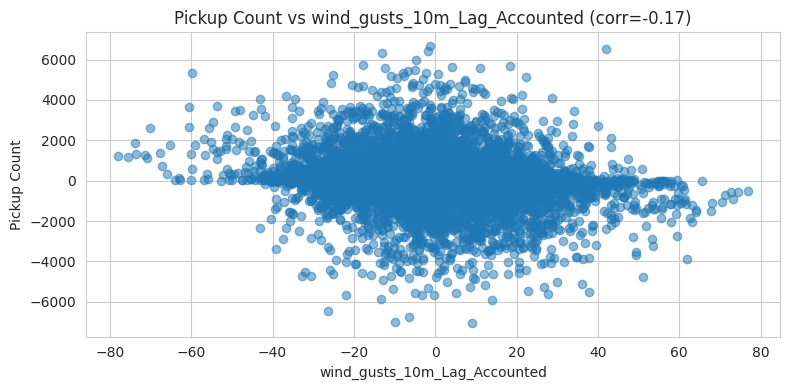

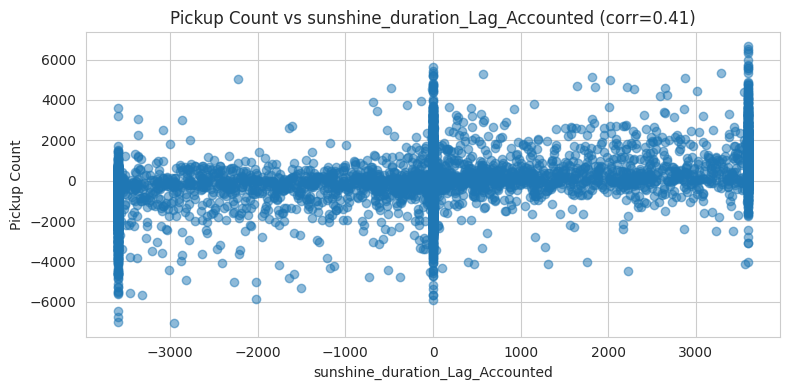

In [43]:
weather_data_corr_df = df_train_pickups.set_index('starttime')
weather_data_corr_df = weather_data_corr_df.resample('h').size().rename('Count').to_frame()
weather_data_corr_df = weather_data_corr_df.join(df_weather, how='left')

weather_data_corr_df['Lag_Accounted_Count'] = weather_data_corr_df['Count'] - weather_data_corr_df['Count'].shift(168)

# difference weather data, not taking into account day and night

weather_cols = [c for c in df_weather.columns] # if we want to include all columns

for col in weather_cols:
    weather_data_corr_df[f'{col}_Lag_Accounted'] = weather_data_corr_df[col] - weather_data_corr_df[col].shift(168)

weather_data_corr_df = weather_data_corr_df.dropna()
# drop columns without lagged features
weather_data_corr_df = weather_data_corr_df[[c for c in weather_data_corr_df.columns if 'Lag_Accounted' in c]]

for col in weather_data_corr_df.columns:
    if col == 'Lag_Accounted_Count':
        continue
    plt.figure(figsize=(8,4))
    plt.scatter(weather_data_corr_df[col], weather_data_corr_df['Lag_Accounted_Count'], alpha=0.5)
    corr = weather_data_corr_df[col].corr(weather_data_corr_df['Lag_Accounted_Count'])
    plt.title(f'Pickup Count vs {col} (corr={corr:.2f})')
    plt.xlabel(col)
    plt.ylabel('Pickup Count')
    plt.tight_layout()
    plt.show()

Check for one cluster if the predicitons are better when including the weather:

In [44]:
se = StationEvaluator(df_train_pickups[df_train_pickups['start_centroid'] == 8], df_weather=df_weather, use_weather=True)
eval_pickup = se.evaluate_predictors()
eval_pickup

Method Window Index Difference  \
0                                   Day by Day      1               24   
1                                   Day by Day      7               24   
2                          Residual Regression    N/A              N/A   
3  Residual Regression (weather and day/night)    N/A              N/A   
4        Residual Regression with weather data    N/A              N/A   
5                                 Week by Week      1              168   
6                                 Week by Week      4              168   

     Mean_MSE    Std_MSE  
0  161.062037  36.578818  
1  117.349103  24.204385  
2   78.082549  21.042633  
3   60.651325  15.053431  
4   61.545403  13.874201  
5  115.697470  28.924378  
6   79.200295  20.002961

In [45]:
performance_with_weather = evaluate_model_performance(df_train_pickups, df_test_pickups, df_train_dropoffs, df_test_dropoffs, df_weather, include_weather=True)
performance_with_weather

{'method': 'Residual Regression (weather and day/night)', 'window': 'N/A', 'index_difference': 'N/A'}
{'method': 'Residual Regression (weather and day/night)', 'window': 'N/A', 'index_difference': 'N/A'}
{'method': 'Residual Regression (weather and day/night)', 'window': 'N/A', 'index_difference': 'N/A'}
{'method': 'Residual Regression (weather and day/night)', 'window': 'N/A', 'index_difference': 'N/A'}
{'method': 'Residual Regression (weather and day/night)', 'window': 'N/A', 'index_difference': 'N/A'}
{'method': 'Residual Regression (weather and day/night)', 'window': 'N/A', 'index_difference': 'N/A'}
{'method': 'Residual Regression (weather and day/night)', 'window': 'N/A', 'index_difference': 'N/A'}
{'method': 'Residual Regression (weather and day/night)', 'window': 'N/A', 'index_difference': 'N/A'}
{'method': 'Residual Regression (weather and day/night)', 'window': 'N/A', 'index_difference': 'N/A'}
{'method': 'Residual Regression (weather and day/night)', 'window': 'N/A', 'index_

[{'error': 2018-11-08    358.648211
  2018-11-09    336.197528
  2018-11-10    380.037771
  2018-11-11    244.689444
  2018-11-12     71.222888
  2018-11-13    340.752235
  2018-11-14    305.893453
  2018-11-15    386.088052
  2018-11-16    541.328311
  2018-11-17    356.116108
  2018-11-18    352.792821
  2018-11-19     51.306395
  2018-11-20     70.054532
  2018-11-21    410.343399
  2018-11-22    680.482554
  2018-11-23    513.721714
  2018-11-24    404.173246
  2018-11-25    225.798893
  2018-11-26     95.290168
  2018-11-27     26.922015
  2018-11-28    199.094438
  2018-11-29     56.289382
  2018-11-30     23.391180
  2018-12-01    239.417613
  2018-12-02    339.768201
  2018-12-03    299.471055
  2018-12-04    216.126374
  2018-12-05    352.766589
  2018-12-06    253.774586
  2018-12-07    252.945578
  2018-12-08    302.648939
  2018-12-09    237.681486
  2018-12-10    322.563756
  2018-12-11    236.162694
  2018-12-12    266.857445
  2018-12-13    321.531073
  2018-12-14    167

In [46]:
concated_error_with_weather = None
coverage_rates_with_weather = []
for perf in performance_with_weather:
    if concated_error_with_weather is None:
        concated_error_with_weather = perf['error']
    else:
        concated_error_with_weather = pd.concat([concated_error_with_weather, perf['error']])
    coverage_rates_with_weather.append(perf['daily_coverage'])

concated_error_with_weather.values

sum_neg = concated_error_with_weather[concated_error_with_weather < 0].sum() 
sum_pos = concated_error_with_weather[concated_error_with_weather > 0].sum() 

mean_neg = concated_error_with_weather[concated_error_with_weather < 0].mean() 
mean_pos = concated_error_with_weather[concated_error_with_weather > 0].mean() 

print("Sum of the negative concated errors/underestimation of demand:", sum_neg)
print("Sum of the positive concated errors/overestimation of demand:", sum_pos)
print("mean of the negative concated errors/underestimation of demand:",mean_neg )
print("mean of the positive concated errors/overestimation of demand:", mean_pos)

print("mean daily_coverage rate:", np.mean(coverage_rates_with_weather))
print("std daily_coverage rate:", np.std(coverage_rates_with_weather))

Sum of the negative concated errors/underestimation of demand: -220.11075390844303
Sum of the positive concated errors/overestimation of demand: 326537.4039917524
mean of the negative concated errors/underestimation of demand: -24.45675043427145
mean of the positive concated errors/overestimation of demand: 189.95776846524282
mean daily_coverage rate: 0.9947916666666666
std daily_coverage rate: 0.009526665296964295


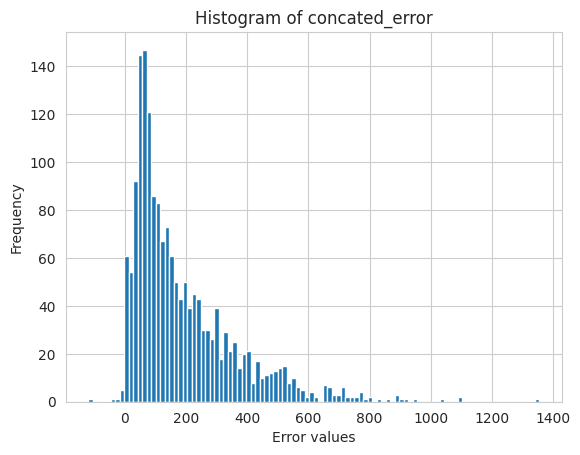

In [ ]:
# Assuming concated_error is a Pandas Series or NumPy array
plt.hist(concated_error_with_weather.values, bins=100)  
plt.xlabel("Error values")
plt.ylabel("Number of occurrences")
plt.title("Daily ")
plt.show()